# TL;DR

The goal of this notebook is to visualize COVID-19 infections using data from https://github.com/CSSEGISandData/COVID-19.

Most illustrative plots of how the pandemic is being controlled:
- [Relative increases per day by country](#country_relative_increases)
- [Relative increases per day by state](#us_state_relative_increases)

Visualizations found in this notebook:
- [Top 20 countries by cumulative confirmed COVID-19 cases](#top_countries_confirmed)
- [Top 10 countries by NEW confirmed COVID-19 cases](#top_countries_confirmed_new)
- [Time-series plots of infections in most infected countries](#time-series_countries)
- [Forecasts of infections/deaths 1 and 7 days in the future](#forecasts_countries)
- [Relative increases per day by country](#country_relative_increases)
- [Time-series plots of mortality](#time-series_country_mortality)
- [Mortality as currently measured, compared to expected based on WHO mortality expectations](#counry_mortality_expectations)
  - [Source of expectations](http://weekly.chinacdc.cn/en/article/id/e53946e2-c6c4-41e9-9a9b-fea8db1a8f51)
- [Density of infections per million people](#density_of_infections_by_country)
- [How many days behind is each country from Italy?](#days_behind)
- [US states with the most new infections](#states_most_infections)
- [Time-series plots of infections in most-infected states](#time-series_states)
- [State forecasts of infections/deaths 1 and 7 days in the future](#forecast_us_state)
- [States and their daily increase fraction in confirmed cases/deaths](#us_state_daily_increase_fraction)
- [Compare US state infections against Washington](#state_infections_vs_wa)
- [Compare US state infections against New York](#state_infections_vs_ny)
- [Mortality rate by US state](#mortality_by_us_state)
- [Relative increases per day by state](#us_state_relative_increases)
- [When will each US state hit 1 case?](#us_state_0_new)

In [1]:


from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')



# Imports and definitions

In [2]:
import pandas as pd
import numpy as np
import os
import datetime
import re
from dateutil import parser
from matplotlib import pyplot as plt
import warnings

plt.rcParams['figure.figsize'] = 12,6
#plt.style.use('seaborn-dark-palette')
plt.style.use('seaborn-darkgrid')
pd.options.display.max_columns = 300

def datetime_to_unixtime(dt):
    return (dt - datetime.datetime(1970, 1, 1)).total_seconds()

# Load data

In [70]:
# define paths to each raw file
d_ts = {}
#d_ts['confirmed'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
#d_ts['deaths'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
d_ts['confirmed'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
d_ts['deaths'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'

#d_ts['recovered'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'

# load in each CSV
d_data = {}
for key, file_path in d_ts.items():
    d_data[key] = pd.read_csv(file_path)

# Clean to long form

In [71]:
def clean_wide_to_long(dfp, key):
    # find columns with dates in them
    cols = list(dfp.columns)
    date_cols = [col for col in cols if re.findall('(\d+/\d+/\d+)', col)]  #if '/' in col
    non_date_cols = list(set(cols) - set(date_cols))
    
    # wide to long
    dfp_melt = pd.melt(dfp, id_vars=non_date_cols, value_vars=date_cols)
    dfp_melt = dfp_melt.rename(columns={'variable': 'date', 
                                        'value': key,
                                        'Country/Region': 'country',
                                        'Province/State': 'state',
                                       })
    dfp_melt['date'] = dfp_melt['date'].apply(parser.parse)
    dfp_melt[key] = dfp_melt[key].apply(float)
    return dfp_melt

In [72]:
# convert from wide to long form
d_dfps = {}
dfp = None
merge_cols = ['country', 'state', 'date']
for key, dfp_wide in d_data.items():
    print(f'metric: {key} at {datetime.datetime.now()}')
    d_dfps[key] = clean_wide_to_long(dfp_wide, key)
    
    if dfp is None:
        dfp = d_dfps[key].copy()
    else:
        dfp_temp = d_dfps[key][merge_cols + [key]]
        dfp = dfp.merge(dfp_temp, on=merge_cols, how='left')
        
print(f"Latest data from {dfp['date'].max().strftime('%Y-%m-%d')}")

metric: confirmed at 2020-05-26 09:17:41.336436
metric: deaths at 2020-05-26 09:17:42.869990
Latest data from 2020-05-25


In [73]:
# aggregate by country (the US data is reported by state)
dfp_country = (dfp.groupby(['date', 'country'], as_index=False).
               agg({
                   'confirmed': np.sum,
                   'deaths': np.sum,
                   #'recovered': np.sum,
               }))
#dfp_country['active'] = dfp_country['confirmed'] - dfp_country['recovered']
dfp_country['confirmed_lag1'] = dfp_country.groupby(['country'])['confirmed'].shift(1)
dfp_country['confirmed_new'] = dfp_country['confirmed'] - dfp_country['confirmed_lag1']
dfp_country['deaths_lag1'] = dfp_country.groupby(['country'])['deaths'].shift(1)
dfp_country['deaths_new'] = dfp_country['deaths'] - dfp_country['deaths_lag1']
dfp_country['mortality_rate'] = dfp_country['deaths'] / dfp_country['confirmed']

<a id='top_countries_confirmed'></a>
##### Top 20 countries by cumulative confirmed COVID-19 cases

In [74]:
# get the top countries
id_cols = ['date', 'country']
value_cols = [
    'confirmed',
    'confirmed_new',
    'deaths',
    'deaths_new',
    #'active',
    'mortality_rate',
]
dfp_top_countries = dfp_country[dfp_country['date'] == dfp_country['date'].max()][id_cols + value_cols]
dfp_top_countries = dfp_top_countries.sort_values(by='deaths', ascending=0).reset_index(drop=True)
for key in value_cols:
    if 'rate' in key:
        continue
    dfp_top_countries[key] = dfp_top_countries[key].apply(int)
dfp_top_countries.head(20)

date         country  confirmed  confirmed_new  deaths  deaths_new  \
0  2020-05-25              US    1662302          19056   98220         500   
1  2020-05-25  United Kingdom     262547           1631   36996         121   
2  2020-05-25           Italy     230158            300   32877          92   
3  2020-05-25          France     183067            358   28460          90   
4  2020-05-25           Spain     235400           -372   26834       -1918   
5  2020-05-25          Brazil     374898          11687   23473         807   
6  2020-05-25         Belgium      57342            250    9312          32   
7  2020-05-25         Germany     180600            272    8309          26   
8  2020-05-25          Mexico      71105           2485    7633         239   
9  2020-05-25            Iran     137724           2023    7451          34   
10 2020-05-25          Canada      87119           1013    6655         121   
11 2020-05-25     Netherlands      45647            210    5849           8   
12 2020-05-25           China      84102              7    4638           0   
13 2020-05-25          Turkey     157814            987    4369          29   
14 2020-05-25           India     144950           6414    4172         148   
15 2020-05-25          Sweden      33843            384    4029          31   
16 2020-05-25          Russia     353427           8946    3633          92   
17 2020-05-25            Peru     123979           4020    3629         173   
18 2020-05-25         Ecuador      37355            599    3203          95   
19 2020-05-25     Switzerland      30746             10    1913           7   

    mortality_rate  
0         0.059087  
1         0.140912  
2         0.142845  
3         0.155462  
4         0.113993  
5         0.062612  
6         0.162394  
7         0.046008  
8         0.107348  
9         0.054101  
10        0.076390  
11        0.128135  
12        0.055147  
13        0.027684  
14        0.028782  
15        0.119050  
16        0.010279  
17        0.029271  
18        0.085745  
19        0.062219

<a id='top_countries_confirmed_new'></a>
##### Top 10 countries by NEW confirmed COVID-19 cases

In [75]:
dfp_top_countries.sort_values(by='confirmed_new', ascending=0).head(10)

date       country  confirmed  confirmed_new  deaths  deaths_new  \
0  2020-05-25            US    1662302          19056   98220         500   
5  2020-05-25        Brazil     374898          11687   23473         807   
16 2020-05-25        Russia     353427           8946    3633          92   
14 2020-05-25         India     144950           6414    4172         148   
29 2020-05-25         Chile      73997           4895     761          43   
17 2020-05-25          Peru     123979           4020    3629         173   
8  2020-05-25        Mexico      71105           2485    7633         239   
40 2020-05-25  Saudi Arabia      74795           2235     399           9   
9  2020-05-25          Iran     137724           2023    7451          34   
35 2020-05-25    Bangladesh      35585           1975     501          21   

    mortality_rate  
0         0.059087  
5         0.062612  
16        0.010279  
14        0.028782  
29        0.010284  
17        0.029271  
8         0.107348  
40        0.005335  
9         0.054101  
35        0.014079

<a id='time-series_countries'></a>
# Time-series plots of infections in most infected countries

In [76]:
def plot_countries(
    dfp_country,
    countries=dfp_top_countries.iloc[:10]['country'],
    plot_cols=['confirmed', 'deaths', 'recovered', 'active', 'confirmed_new'],
    country_col='country',
    n_columns=2,
    y_min=1,
    y_max=dfp_top_countries['confirmed'].max() * 1.5,
    date_col='date',
    y_label='num_cases',
    date_min=datetime.datetime(2020,2,1),
    is_log=True,
):
    i = 1
    n_rows = int(np.ceil(len(countries) / n_columns))
    plt.figure(figsize=(12,n_rows*5))
    
    for country in countries:
        dfp_plot = dfp_country[(dfp_country[country_col] == country) &
                               (dfp_country[date_col] >= date_min)
                              ]
        dfp_plot = dfp_plot[dfp_plot['confirmed_new'] != 0]
        plt.subplot(n_rows, n_columns, i)
        for key in plot_cols:
            plt.plot(dfp_plot[date_col], dfp_plot[key], alpha=0.7, label=key)
        plt.legend(loc='best')
        plt.ylabel(f'{y_label}')
        plt.title(f'{country_col}: {country}')
        if is_log:
            plt.yscale('log')
        plt.ylim([y_min, y_max])
        plt.xticks(rotation=90)

        i += 1
    plt.tight_layout()
    plt.show()

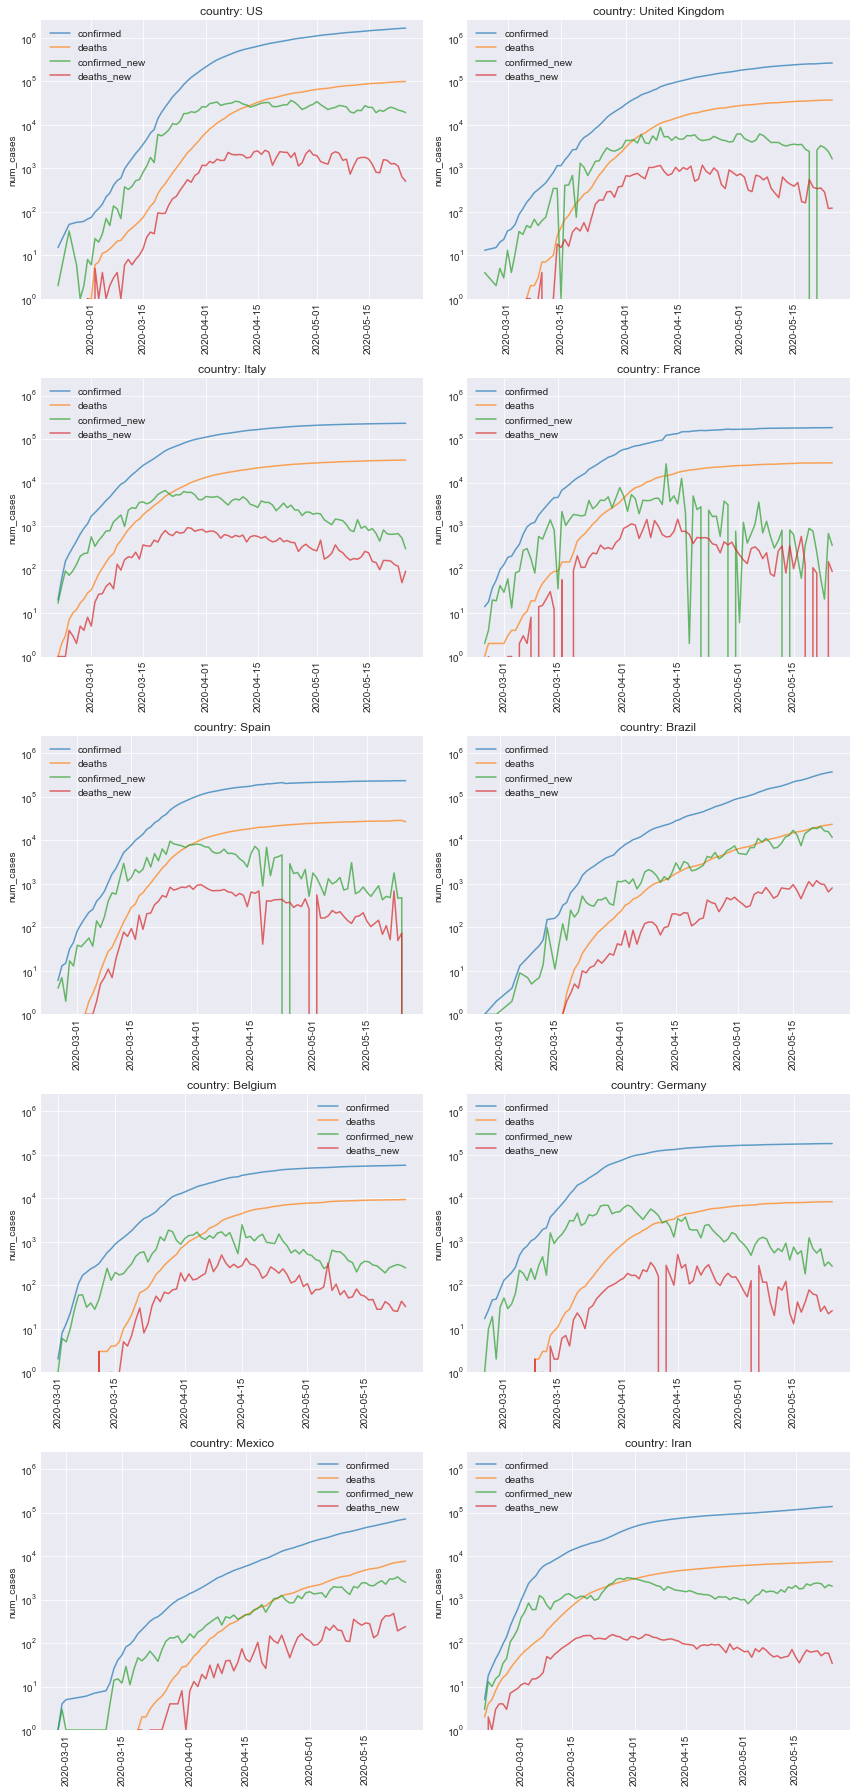

In [77]:
n_countries = 10

plot_countries(dfp_country, 
               countries=dfp_top_countries.iloc[:n_countries]['country'],
               plot_cols=['confirmed', 'deaths', 'confirmed_new', 'deaths_new'], #, 'recovered', 'active'
               country_col='country',
               date_min=datetime.datetime(2020,2,20),
              )

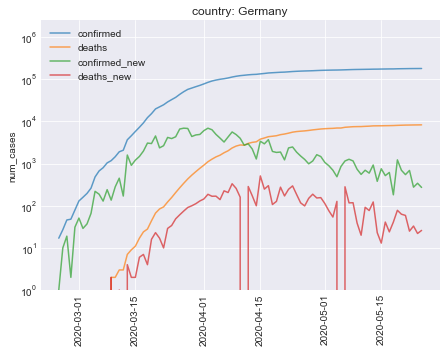

In [78]:
plot_countries(dfp_country, 
               countries=['Germany'],
               plot_cols=['confirmed', 'deaths', 'confirmed_new', 'deaths_new'], #, 'recovered', 'active'
               country_col='country',
               date_min=datetime.datetime(2020,2,20),
              )

<a id='forecasts_countries'></a>
# Forecasts of infections/deaths 1 and 7 days in the future

For confirmed cases (`confirmed_pred`) and deaths (`deaths_pred`)

In [79]:
def predict_from_fit(row):
    return int(10**(row['slope'] * row['unixtime'] + row['intercept']))

def shift_future(dfp, date_most_recent, days=1):
    dfp_most_recent = dfp.copy()
    dfp_most_recent['date'] = date_most_recent + datetime.timedelta(days=days)  #dfp_most_recent['date'] + datetime.timedelta(days=days)
    dfp_most_recent['unixtime'] = dfp_most_recent['date'].apply(datetime_to_unixtime)
    #dfp_most_recent['unixtime'] = dfp_most_recent['unixtime'] + 86400 * days
    
    for col in ['confirmed', 'deaths', 'recovered', 'active', 'confirmed_lag1', 'confirmed_new', 'deaths_new']:
        dfp_most_recent[col] = np.nan
    return dfp_most_recent

def fit_poly1(dfp_country_recent, 
              col_fit='confirmed_log', 
              col_pred='confirmed_pred', 
              date_most_recent=None,
              col_locale='country'
             ):
    warnings.simplefilter('ignore', np.RankWarning)
    if date_most_recent is None:
        date_most_recent = dfp_country_recent['date'].max()
    dfp_country_recent = dfp_country_recent.set_index(col_locale)
    
    # fit
    dfp_country_recent_clean = dfp_country_recent[(dfp_country_recent['date'] <= date_most_recent) &
                                                  (dfp_country_recent[col_fit] > 0)
                                                 ]
    dfp_country_confirmed_fit = (dfp_country_recent[dfp_country_recent['date'] <= date_most_recent].
                                 groupby([col_locale]).
                                 apply(lambda x: np.polyfit(x['unixtime'], x[col_fit], 1))
                                )
    dfp_country_recent['fits'] = dfp_country_confirmed_fit
    dfp_country_recent[['slope', 'intercept']] = dfp_country_recent['fits'].apply(pd.Series)   
    
    dfp_country_recent[col_pred] = dfp_country_recent.apply(predict_from_fit, axis=1)
    dfp_country_recent = dfp_country_recent.drop(columns=['fits', 'intercept']).reset_index() #'slope', 
    fit_col = col_fit.split('_')[0]
    dfp_country_recent[f"frac_increase_{fit_col}"] = (10**(dfp_country_recent['slope'] * 86400) - 1)
    #dfp_country_recent = dfp_country_recent.rename(columns={'slope': f'slope_{col_fit.split("_")[0]}'})
    return dfp_country_recent, dfp_country_confirmed_fit

def fit_exp(dfp_country, 
            n_days_predict=14, 
            n_days_into_future=[1,7],
            col_locale='country', 
            top_countries=None, 
            n_countries=10, 
            date_most_recent=None,
            is_silent=False
           ):
    # make predictions based on the last 2 weeks of data
    if date_most_recent is None:
        date_most_recent = dfp_country['date'].max()
    date_n_days_ago = date_most_recent - datetime.timedelta(days=n_days_predict-1)
    dfp_country_recent = (dfp_country[dfp_country['date'].between(date_n_days_ago, date_most_recent)].
                          sort_values(by=[col_locale, 'date'])
                         ).copy()

    # clean data for fit (convert to log)
    dfp_country_recent['confirmed_log'] = dfp_country_recent['confirmed'].apply(lambda x: np.log10(x) if x > 0 else 0)
    dfp_country_recent['deaths_log'] = dfp_country_recent['deaths'].apply(lambda x: np.log10(x) if x > 0 else 0)
    dfp_country_recent['unixtime'] = dfp_country_recent['date'].apply(datetime_to_unixtime)
    
    
    # make predictions to past, then future
    # add in future points
    dfp_country_recent_max_date = dfp_country_recent.groupby([col_locale], as_index=False).agg({'date': np.max})
    dfp_most_recent = dfp_country_recent.merge(dfp_country_recent_max_date, on=[col_locale, 'date'], how='inner').copy()
    #dfp_most_recent = dfp_country_recent[dfp_country_recent['date'] == date_most_recent].copy()
    list_dfp_recent = [dfp_country_recent]
    for n in n_days_into_future:
        dfp_most_recent_tmp = shift_future(dfp_most_recent, date_most_recent, n)
        list_dfp_recent.append(dfp_most_recent_tmp)
    #dfp_most_recent_7 = shift_future(dfp_most_recent, 7)
    #dfp_country_recent = pd.concat([dfp_country_recent, dfp_most_recent_1, dfp_most_recent_7], axis=0, sort=False)
    dfp_country_recent = pd.concat(list_dfp_recent, axis=0, sort=False)
    dfp_country_recent, dfp_country_deaths_fit = fit_poly1(dfp_country_recent, 
                                                           col_fit='deaths_log', 
                                                           col_pred='deaths_pred', 
                                                           col_locale=col_locale, 
                                                           date_most_recent=date_most_recent
                                                          )
    dfp_country_recent, dfp_country_confirmed_fit = fit_poly1(dfp_country_recent, 
                                                              col_fit='confirmed_log', 
                                                              col_pred='confirmed_pred', 
                                                              col_locale=col_locale, 
                                                              date_most_recent=date_most_recent
                                                             )
    dfp_country_recent['mortality_rate_pred'] = dfp_country_recent['deaths_pred'] / dfp_country_recent['confirmed_pred']

    # look only at the predictions for top countries
    if top_countries is None:
        top_countries = (dfp_most_recent.
                         sort_values(by='deaths', ascending=0).iloc[:n_countries][col_locale].values)
    dfp_forecasts = dfp_country_recent[(dfp_country_recent['date'] > date_most_recent)
                                       
                                      ].sort_values(by=[col_locale, 'date']).reset_index(drop=True)
    dfp_forecasts_out = dfp_forecasts[['date', 
                                       col_locale, 
                                       'confirmed_pred', 
                                       'deaths_pred', 
                                       'mortality_rate_pred', 
                                       'frac_increase_confirmed', 
                                       'frac_increase_deaths'
                                      ]].copy()
    dfp_forecasts_out['date'] = dfp_forecasts_out['date'].apply(lambda x: x.strftime('%Y-%m-%d'))

    # find the daily fractional increase in cases
    dfp_frac_increase = (dfp_forecasts_out.
                         groupby([col_locale]).
                         agg({'frac_increase_confirmed': np.mean, 
                              'frac_increase_deaths': np.mean}))
    dfp_frac_increase.columns = pd.MultiIndex.from_product([dfp_frac_increase.columns, ['']])

    # pivot so each date of prediction has its own column
    dfp_forecasts_print = dfp_forecasts_out.pivot(index=col_locale, 
                                                  columns='date', 
                                                  values=['confirmed_pred', 'deaths_pred', 'mortality_rate_pred']
                                                 ).sort_values(by=('deaths_pred', dfp_forecasts_out['date'].min()), ascending=0)
    dfp_forecasts_print = dfp_forecasts_print.merge(dfp_frac_increase, on=col_locale, how='inner')
    if not is_silent:
        display(dfp_forecasts_print[dfp_forecasts_print.index.isin(top_countries)])
    return dfp_country_recent, dfp_forecasts_out


def plot_forecasts(dfp_country_recent, 
                   n_countries=10, 
                   n_columns=2, 
                   figsize=(12,24), 
                   date_min=datetime.datetime(2020, 2, 1),
                   col_locale='country',
                  ):
    # subset the top countries
    dfp_non_pred = dfp_country_recent.dropna(subset=['deaths'])
    dt_max = dfp_non_pred['date'].max()
    dfp_top_countries = (dfp_non_pred[dfp_non_pred['date'] == dt_max].
                         sort_values(by='deaths', ascending=0).
                         iloc[:n_countries]
                        )
    top_countries = (dfp_top_countries.
                     iloc[:n_countries][col_locale].values
                    )

    # plot the top countries
    i = 1
    n_rows = int(np.ceil(n_countries / n_columns))
    plt.figure(figsize=figsize)
    y_max = dfp_country_recent['confirmed_pred'].max()
    y_min = max(dfp_country_recent['deaths'].min(), 1)

    for country in top_countries:
        dfp_plot = dfp_country_recent[(dfp_country_recent[col_locale] == country) &
                               (dfp_country_recent['date'] >= date_min)
                              ].sort_values(by='date')
        plt.subplot(n_rows, n_columns, i)
        for key in ['confirmed', 'deaths']:
            p = plt.plot(dfp_plot['date'], dfp_plot[key], alpha=0.5, linewidth=2, label=key)
            pred_col = f'{key}_pred'
            plt.plot(dfp_plot['date'], dfp_plot[pred_col], linestyle='--', linewidth=2, alpha=0.5, color=p[0].get_color(), label=pred_col)
        plt.legend(loc='best')
        plt.ylabel('num cases')
        plt.title(f'{col_locale}: {country}')
        plt.yscale('log')
        plt.ylim([y_min, y_max])
        plt.xticks(rotation=90)

        i += 1
    plt.tight_layout()
    plt.show()
    return None
                       
                       
def save_forecast(dfp_forecasts_out, dfp_country_recent, n_days_training=14):
    date_most_recent = dfp_country_recent.dropna(subset=['deaths'])['date'].max()
    dfp_forecasts_out['date_of_forecast'] = date_most_recent
    save_name = f"covid-19_country_forecast_from_{date_most_recent.strftime('%Y-%m-%d')}_n_days_training={n_days_training}.csv"
    save_path = os.path.join('predictions', save_name)
    dfp_forecasts_out.to_csv(save_path, index=False)
    print(f'saved forecast to {save_path}')
    return None

##### Forecasts based on last 1 week

confirmed_pred                       deaths_pred             \
date               2020-05-26 2020-06-01 2020-06-15  2020-05-26 2020-06-01   
country                                                                      
US                  1690068.0  1839146.0  2240150.0     99930.0   106870.0   
United Kingdom       265206.0   280298.0   318938.0     37438.0    39142.0   
Italy                230975.0   234618.0   243342.0     33043.0    33765.0   
France               183276.0   185120.0   189495.0     28489.0    28875.0   
Spain                236826.0   240935.0   250801.0     27997.0    27897.0   
Brazil               403903.0   559028.0  1193440.0     24886.0    32604.0   
Belgium               57608.0    59257.0    63289.0      9344.0     9547.0   
Germany              181299.0   184170.0   191045.0      8362.0     8588.0   
Mexico                75041.0    98979.0   188851.0      8216.0    11043.0   
Iran                 140310.0   155028.0   195655.0      7524.0     7880.0   

                          mortality_rate_pred                        \
date           2020-06-15          2020-05-26 2020-06-01 2020-06-15   
country                                                               
US               124994.0            0.059128   0.058108   0.055797   
United Kingdom    43427.0            0.141166   0.139644   0.136161   
Italy             35512.0            0.143059   0.143915   0.145935   
France            29797.0            0.155443   0.155980   0.157244   
Spain             27666.0            0.118218   0.115786   0.110311   
Brazil            61235.0            0.061614   0.058323   0.051310   
Belgium           10038.0            0.162200   0.161112   0.158606   
Germany            9139.0            0.046123   0.046631   0.047837   
Mexico            22015.0            0.109487   0.111569   0.116573   
Iran               8779.0            0.053624   0.050830   0.044870   

               frac_increase_confirmed frac_increase_deaths  
date                                                         
country                                                      
US                            0.014188             0.011252  
United Kingdom                0.009267             0.007447  
Italy                         0.002611             0.003610  
France                        0.001670             0.002247  
Spain                         0.002871            -0.000594  
Brazil                        0.055665             0.046049  
Belgium                       0.004713             0.003585  
Germany                       0.002621             0.004451  
Mexico                        0.047227             0.050515  
Iran                          0.016764             0.007741

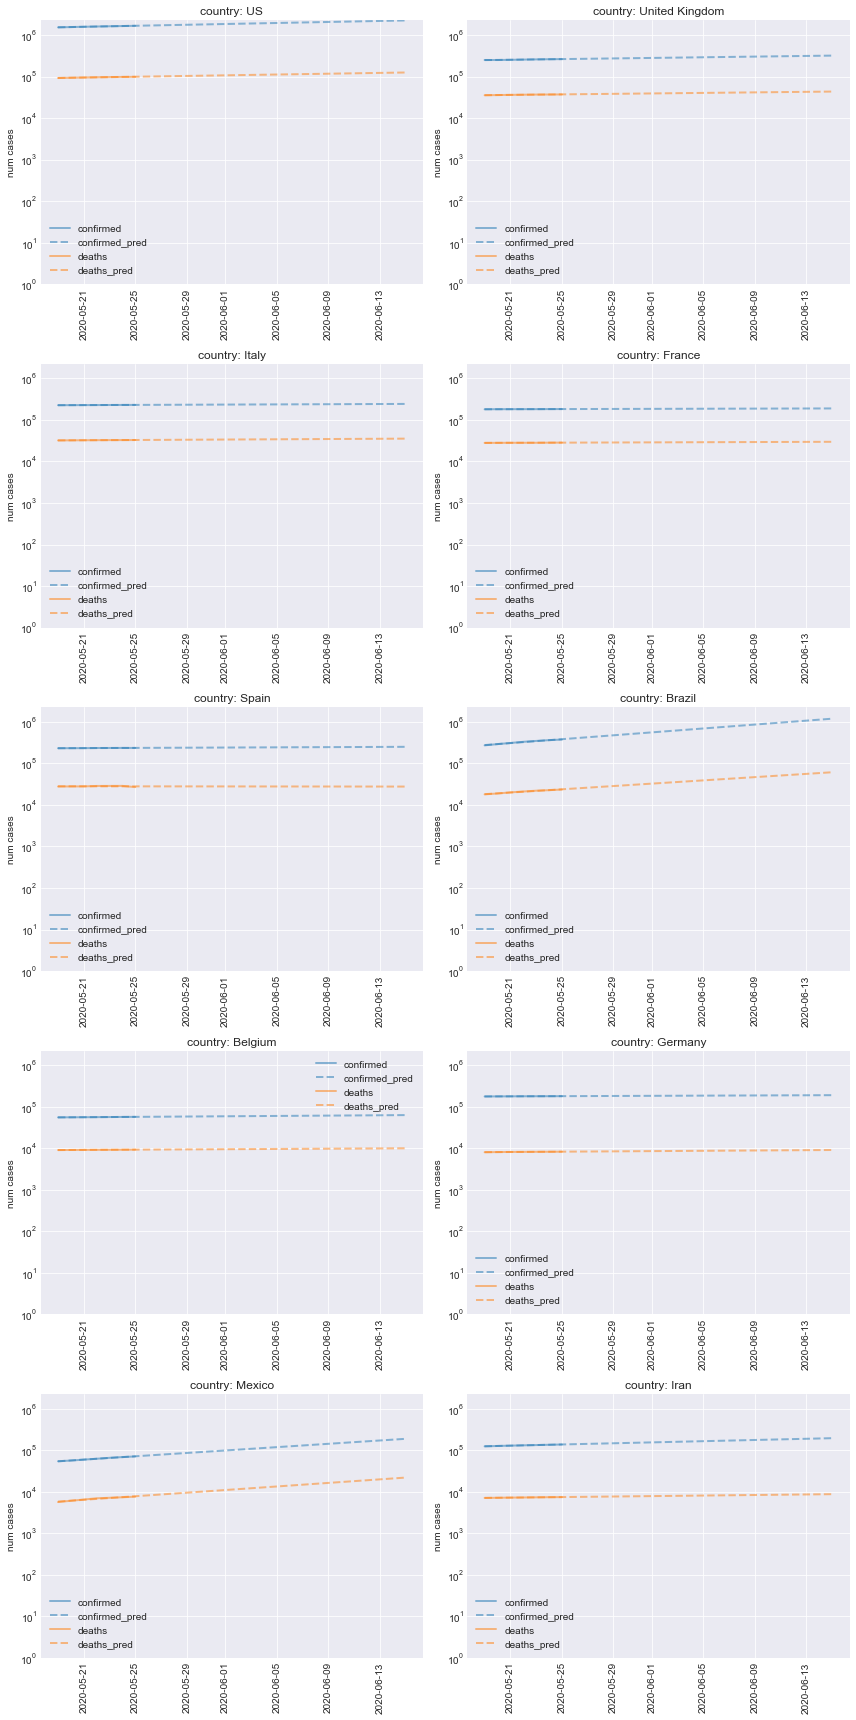

In [80]:
dfp_country_recent_1, dfp_forecasts_out_1 = fit_exp(dfp_country, 
                                                    n_days_predict=7,
                                                    n_days_into_future=[1,7,21], 
                                                    col_locale='country', 
                                                    top_countries=None
                                                   )
plot_forecasts(dfp_country_recent_1)

In [81]:
save_forecast(dfp_forecasts_out_1, dfp_country_recent_1, 7)

saved forecast to predictions/covid-19_country_forecast_from_2020-05-25_n_days_training=7.csv


<a id='country_relative_increases'></a>
### Relative increases per day by country

In [82]:
def find_relative_increase_data_and_plot(dfp_us_g, 
                                         n_days_fit=7, 
                                         dt=datetime.datetime(2020,3,10),
                                         n_locales=7,
                                         col_locale='state'
                                        ):
    dt_max = dfp_us_g['date'].max()
    list_dfp_state_relative = []
    while dt <= dt_max:
        try:
            dfp_state_recent_tmp, dfp_state_forecasts_out_tmp = fit_exp(dfp_us_g, 
                                                                        n_days_predict=n_days_fit, 
                                                                        col_locale=col_locale, 
                                                                        top_countries=None,
                                                                        date_most_recent=dt,
                                                                        is_silent=True
                                                                       )
            dfp_state_recent_tmp = dfp_state_recent_tmp.dropna(subset=['confirmed'])
            dfp_state_recent_tmp_single = dfp_state_recent_tmp[dfp_state_recent_tmp['date'] == dfp_state_recent_tmp['date'].max()]
            list_dfp_state_relative.append(dfp_state_recent_tmp_single)
        except Exception as e:
            print(f"failed on {dt.strftime('%Y-%m-%d')}")

        dt += datetime.timedelta(days=1)
    dfp_state_relative_chng = pd.concat(list_dfp_state_relative)
                  
    # plot states
    top_states = (dfp_state_relative_chng[(dfp_state_relative_chng['date'] == dfp_state_relative_chng['date'].max())].
                  sort_values(by='deaths', ascending=0).
                  reset_index(drop=True).
                  iloc[:n_locales][col_locale].values
                 )
                  
    # deaths
    plt.subplot(1,2,1)
    for state in top_states:
        dfp_st = dfp_state_relative_chng[(dfp_state_relative_chng[col_locale] == state) & 
                                         (dfp_state_relative_chng['deaths'] > 2)]
        #
        plt.plot(dfp_st['date'], dfp_st['frac_increase_deaths'], label=state, alpha=0.7)
        plt.ylabel('relative increase in deaths')
        plt.xticks(rotation=90)
        plt.legend(loc='best')
        plt.axhline(0, color='k', alpha=0.5)
        plt.title('Relative daily increase in deaths')

    # confirmed cases
    plt.subplot(1,2,2)
    for state in top_states:
        dfp_st = dfp_state_relative_chng[(dfp_state_relative_chng[col_locale] == state) & 
                                         (dfp_state_relative_chng['deaths'] > 2)]
        
        plt.plot(dfp_st['date'], dfp_st['frac_increase_confirmed'], label=state, alpha=0.7)
        plt.ylabel('relative increase in confirmed')
        plt.xticks(rotation=90)
        plt.legend(loc='best')
        plt.axhline(0, color='k', alpha=0.5)
        plt.title('Relative daily increase in confirmed')

    plt.show()
    return None


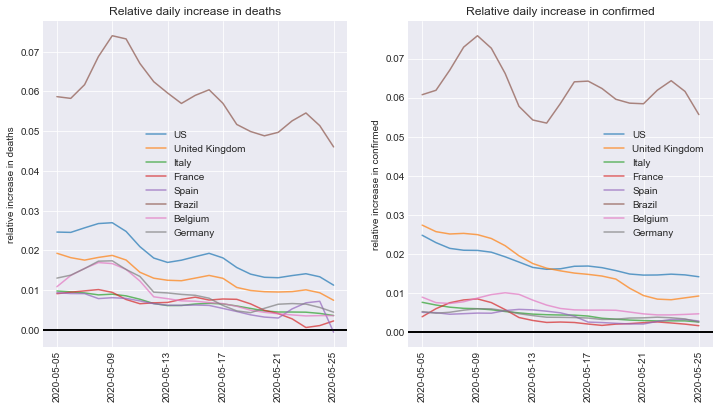

In [83]:
now = datetime.datetime.now()
now = datetime.datetime(now.year, now.month, now.day)
n_days_back = 21
dt_start = now - datetime.timedelta(days=n_days_back)
#dt_start = datetime.datetime(2020,3,2)
find_relative_increase_data_and_plot(dfp_country, n_locales=8, col_locale='country', dt=dt_start)

##### Forecasts based on last 2 weeks

confirmed_pred            deaths_pred             \
date               2020-05-26 2020-06-01  2020-05-26 2020-06-01   
country                                                           
US                  1696442.0  1855626.0    100852.0   109378.0   
United Kingdom       267065.0   284706.0     37725.0    39926.0   
Italy                231395.0   235673.0     33192.0    34142.0   
France               183518.0   185860.0     28707.0    29376.0   
Spain                236599.0   240334.0     28384.0    28928.0   
Brazil               410139.0   581807.0     25261.0    33933.0   
Belgium               57679.0    59414.0      9378.0     9626.0   
Germany              181745.0   185434.0      8386.0     8662.0   
Mexico                75579.0   100724.0      8286.0    11306.0   
Iran                 140444.0   155503.0      7530.0     7901.0   

               mortality_rate_pred            frac_increase_confirmed  \
date                    2020-05-26 2020-06-01                           
country                                                                 
US                        0.059449   0.058944                0.015060   
United Kingdom            0.141258   0.140236                0.010718   
Italy                     0.143443   0.144870                0.003058   
France                    0.156426   0.158054                0.002116   
Spain                     0.119967   0.120366                0.002614   
Brazil                    0.061591   0.058323                0.060005   
Belgium                   0.162590   0.162016                0.004953   
Germany                   0.046142   0.046712                0.003355   
Mexico                    0.109634   0.112247                0.049031   
Iran                      0.053616   0.050809                0.017120   

               frac_increase_deaths  
date                                 
country                              
US                         0.013618  
United Kingdom             0.009495  
Italy                      0.004715  
France                     0.003846  
Spain                      0.003173  
Brazil                     0.050415  
Belgium                    0.004372  
Germany                    0.005400  
Mexico                     0.053152  
Iran                       0.008040

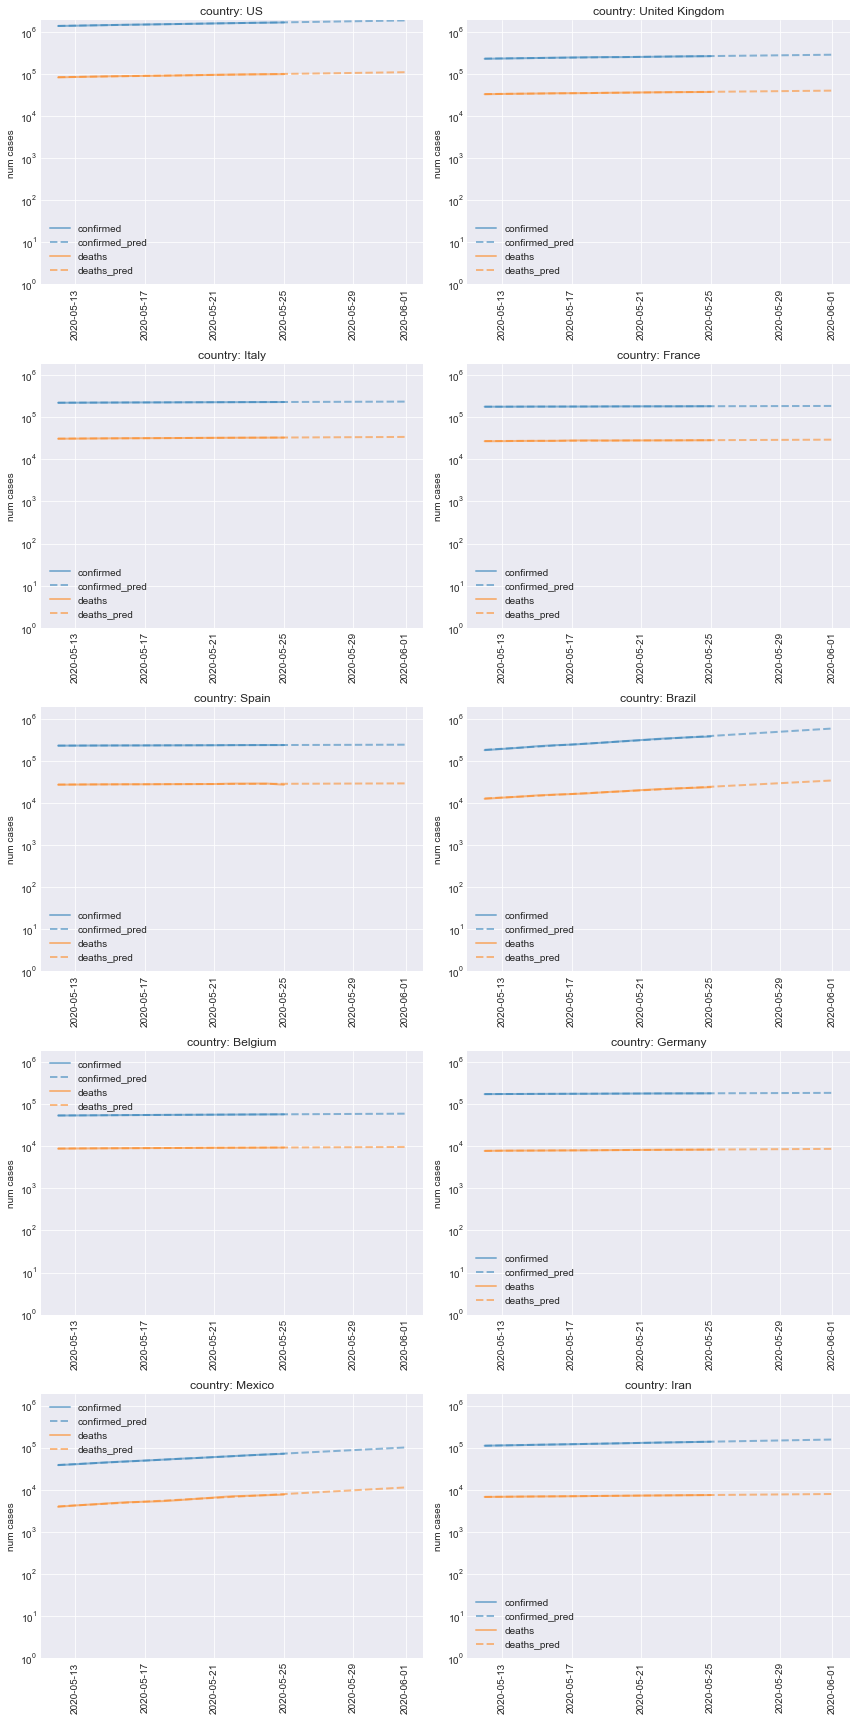

In [84]:
dfp_country_recent_2, dfp_forecasts_out_2 = fit_exp(dfp_country, 
                                                    n_days_predict=14, 
                                                    col_locale='country', 
                                                    top_countries=None
                                                   )
plot_forecasts(dfp_country_recent_2)

In [85]:
save_forecast(dfp_forecasts_out_2, dfp_country_recent_2, 14)

saved forecast to predictions/covid-19_country_forecast_from_2020-05-25_n_days_training=14.csv


<a id='time-series_country_mortality'></a>
# Time-series plots of mortality

In [86]:
def plot_mortality_rate(
    dfp, 
    locales, 
    id_col='country', 
    upper_lim=0.2, 
    date_min=datetime.datetime(2020,2,20),
    dfp_country_mortality_expected=None
):
    
    for locale in locales:
        dfp_plot = dfp[(dfp[id_col] == locale) &
                       (dfp['date'] >= date_min)
                      ]
        p = plt.plot(dfp_plot['date'], dfp_plot['mortality_rate'], label=locale, alpha=0.7)
        
        if dfp_country_mortality_expected is not None:
            dfp_expected = dfp_country_mortality_expected[dfp_country_mortality_expected['country'] == locale]
            
            color = p[0].get_color()
            expected = dfp_expected['frac_mortality'].values[0]
            plt.axhline(expected, 
                        color=color, 
                        alpha=0.5, 
                        linestyle='--', 
                        label=f'{locale} expected = {expected:0.4f}'
                       )
    #plt.legend(loc='best')
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
    if upper_lim is not None:
        plt.ylim([0,upper_lim])
    #plt.yscale('log')
    plt.ylabel('mortality rate')
    plt.title(f'Mortality by {id_col}')
    plt.xticks(rotation=90)
    plt.show()
    return None

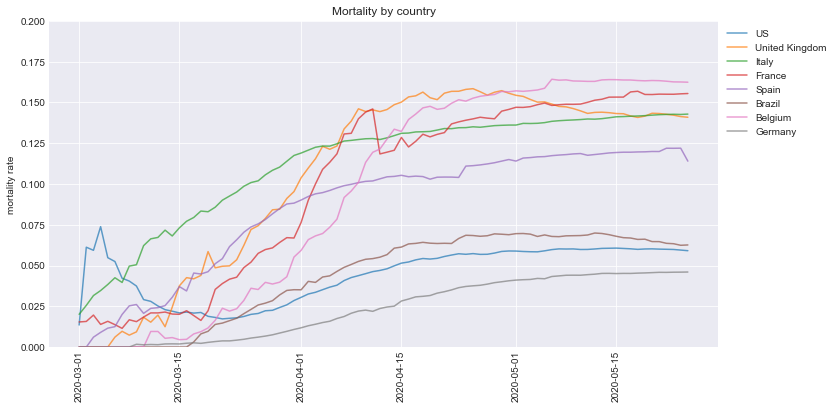

In [87]:
n_countries = 8
countries = dfp_top_countries.iloc[:n_countries]['country']

plot_mortality_rate(dfp_country, countries, upper_lim=0.2, id_col='country', date_min=datetime.datetime(2020,3,1))

### Is mortality rate a function of number of infections?

In [88]:
def plot_mortality_rate_vs_infections(
    dfp, 
    locales, 
    id_col='country', 
    upper_lim=0.2, 
    date_min=datetime.datetime(2020,2,20),
    x_col='confirmed',
    y_col='mortality_rate'
):
    
    for locale in locales:
        dfp_plot = dfp[(dfp[id_col] == locale) &
                       (dfp['date'] >= date_min)
                      ]
        plt.plot(dfp_plot[x_col], dfp_plot[y_col], 'o', label=locale, alpha=0.3)
    plt.legend(loc='best')
    #plt.ylim([0,upper_lim])
    plt.gca().set_ylim(top=upper_lim)
    plt.xscale('log')
    #plt.yscale('log')
    #plt.xlabel('# confirmed cases')
    #plt.ylabel('mortality rate')
    plt.xlabel(x_col.replace('_', ' '))
    plt.ylabel(y_col.replace('_', ' '))
    plt.title(f'{y_col} vs {x_col} by {id_col}')
    plt.xticks(rotation=90)
    plt.show()
    return None

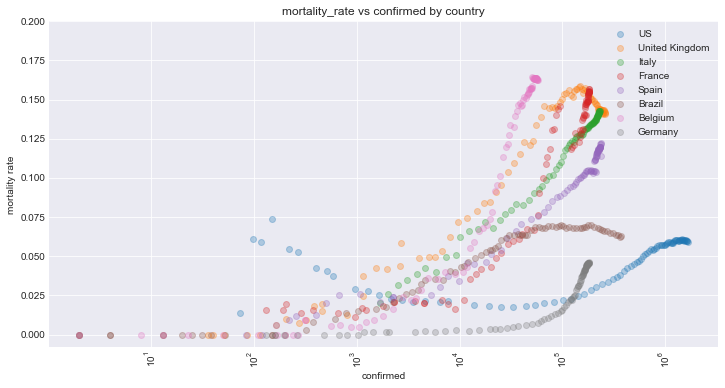

In [89]:
plot_mortality_rate_vs_infections(dfp_country, countries, upper_lim=0.2, id_col='country', date_min=datetime.datetime(2020,3,1))

# Compare mortality rate to expected given country demographics and mortality by age data?

- Country demographic data source: https://www.census.gov/data-tools/demo/idb/region.php?T=10&RT=0&A=both&Y=2020&C=AF&R=1
- Mortality by age source: https://www.worldometers.info/coronavirus/coronavirus-age-sex-demographics/

In [90]:
# mortality data
d_mortality = {0: 0, 10: 0.002, 20: 0.002, 30: 0.002, 40: 0.004, 50: 0.013, 60: 0.036, 70: 0.08, 80: 0.148, 90: 0.148, 100: 0.148}
dfp_mortality = pd.DataFrame.from_dict(d_mortality, orient='index', columns=['mortality_rate']).reset_index(drop=False)
dfp_mortality = dfp_mortality.rename(columns={'index': 'age_decade'})

# demographic data
dfp_demo = pd.read_csv('supporting_data/census_data_20200320_10a682338c.csv', skiprows=1, skipinitialspace=True)

# clean demographic data
dfp_demo = dfp_demo[(dfp_demo['Region'] == 'World') & (dfp_demo['Age'] != 'Total')]
dfp_demo['age_min'] = dfp_demo['Age'].apply(lambda x: np.min([int(y) for y in re.findall('(\d+)', x)]))
dfp_demo['age_mid'] = dfp_demo['age_min'] + 2.5
dfp_demo['age_decade'] = dfp_demo['age_min'].apply(lambda x: int(x / 10) * 10)
dfp_demo = dfp_demo.rename(columns={'Percent Both Sexes': 'pct_pop', 
                                    'Country': 'country',
                                    'Both Sexes Population': 'pop'
                                   })
dfp_demo_decade = dfp_demo.groupby(['country', 'age_decade'], as_index=False).agg({'pct_pop': np.sum, 'pop': np.sum})
dfp_demo_decade.loc[dfp_demo_decade['country'] == 'United States', 'country'] = 'US'

# join mortality with demographics
dfp_demo_decade_mortality = (dfp_demo_decade.merge(dfp_mortality, on=['age_decade'], how='inner').
                             sort_values(by=['country', 'age_decade']).
                             reset_index(drop=True)
                            )
dfp_demo_decade_mortality['frac_mortality'] = dfp_demo_decade_mortality['pct_pop'] * dfp_demo_decade_mortality['mortality_rate'] / 100
dfp_demo_decade_mortality['num_deaths_max_expected'] = dfp_demo_decade_mortality['pop'] * dfp_demo_decade_mortality['mortality_rate']
dfp_country_mortality_expected = (dfp_demo_decade_mortality.
                                  groupby(['country'], as_index=False).
                                  agg({'frac_mortality': np.sum, 
                                       'num_deaths_max_expected': np.sum, 
                                       'pop': np.sum
                                      })
                                 )
dfp_country_mortality_expected.loc[dfp_country_mortality_expected['country'] == 'United States', 'country'] = 'US'

### Age distributions for most infected countries

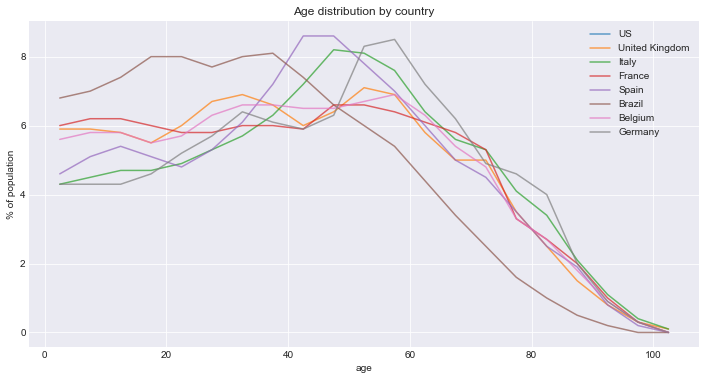

In [91]:
n_countries = 8
countries = dfp_top_countries.iloc[:n_countries]['country']
for country in countries:
    dfp_plot = dfp_demo[dfp_demo.country == country]
    plt.plot(dfp_plot['age_mid'], dfp_plot['pct_pop'], alpha=0.7, label=country)
plt.xlabel('age')
plt.ylabel('% of population')
plt.title('Age distribution by country')
plt.legend(loc='best')
plt.show()

<a id='counry_mortality_expectations'></a>
### Mortality as currently measured, compared to expected based on WHO mortality expectations

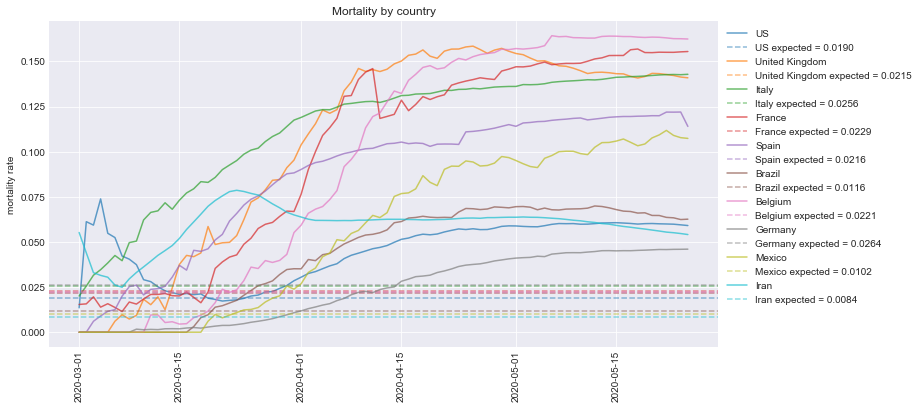

date         country  mortality_rate  confirmed   deaths
0 2020-05-25         Belgium        0.162394    57342.0   9312.0
1 2020-05-25          France        0.155462   183067.0  28460.0
2 2020-05-25           Italy        0.142845   230158.0  32877.0
3 2020-05-25  United Kingdom        0.140912   262547.0  36996.0
4 2020-05-25           Spain        0.113993   235400.0  26834.0
5 2020-05-25          Mexico        0.107348    71105.0   7633.0
6 2020-05-25          Brazil        0.062612   374898.0  23473.0
7 2020-05-25              US        0.059087  1662302.0  98220.0
8 2020-05-25            Iran        0.054101   137724.0   7451.0
9 2020-05-25         Germany        0.046008   180600.0   8309.0

In [92]:
n_countries = 10
countries = dfp_top_countries.iloc[:n_countries]['country']

plot_mortality_rate(dfp_country, countries, upper_lim=None, id_col='country', date_min=datetime.datetime(2020,3,1), dfp_country_mortality_expected=dfp_country_mortality_expected)
dfp_display = (dfp_country[(dfp_country['date'] == dfp_country['date'].max()) & 
                           (dfp_country['country'].isin(countries))
                          ].
               sort_values(by='mortality_rate', ascending=0).
               reset_index(drop=True)
              )[['date', 'country', 'mortality_rate', 'confirmed', 'deaths']]
display(dfp_display)

**Remarks about the mortality rate being above the expected mortality rate**

Assuming the [cited report](https://www.worldometers.info/coronavirus/coronavirus-age-sex-demographics/) of age-wise mortality is correct and that the virus is homogeneously distributed amongst the population, a discrepancy like this could arise if the country has:
- Preferentially tested people in critical condition, ignoring test for mild cases (perhaps if testing capacity is saturated)
- An overloaded hospital system, where patients are not receiving the same quality of care they would otherwise

If the testing is biased, we can estimate the true number of infections by multiplying the confirmed cases by the ratio between the measured mortality rate and the expected mortality rate.  For example, in Iran (as of 2020-03-22), we might estimate the true number of cases is 9.3x higher using this method (200,589 vs 21,638).

### Distribution of expected mortality fractions

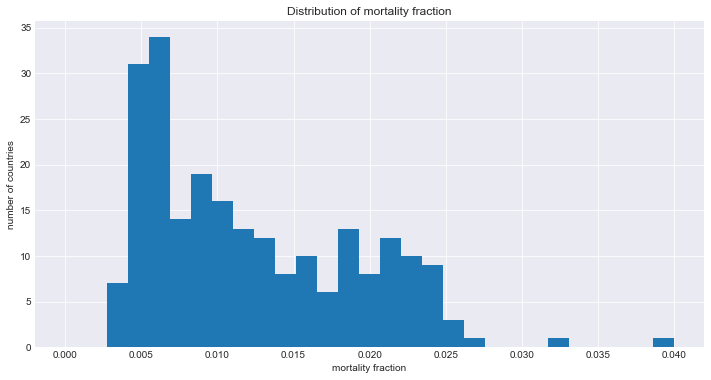

In [93]:
dfp_country_mortality_expected['frac_mortality'].hist(bins=np.linspace(0,0.04,30))
plt.title('Distribution of mortality fraction')
plt.ylabel('number of countries')
plt.xlabel('mortality fraction')
plt.show()

### Top expected mortality fractions based on age demographics
For countries with populations greater than 10 million.

In [94]:
dfp_country_mortality_expected = dfp_country_mortality_expected.sort_values(by='frac_mortality', ascending=0).reset_index(drop=True)
dfp_country_mortality_expected[dfp_country_mortality_expected['pop'] > 1E7].head(10)

country  frac_mortality  num_deaths_max_expected        pop
1         Japan        0.031837              3998380.024  125507472
2       Germany        0.026398              2128411.026   80159662
3        Greece        0.025745               271233.247   10607051
4         Italy        0.025637              1599267.592   62402659
10     Portugal        0.023736               244829.259   10302674
18       France        0.022950              1564984.503   67848156
20       Sweden        0.022575               231555.716   10202491
23      Belgium        0.022146               259573.363   11720716
24  Netherlands        0.022076               382222.125   17280397
27       Canada        0.021712               820035.480   37694085

<a id='density_of_infections_by_country'></a>
# Density of infections per million people

In [95]:
# plot of country fractions that are infected
dfp_country_pop = dfp_country.merge(dfp_country_mortality_expected[['country', 'pop']], on='country', how='left').copy()
dfp_country_pop['deaths_per_million'] = dfp_country_pop['deaths'] / dfp_country_pop['pop'] * 1E6
dfp_country_pop['confirmed_per_million'] = dfp_country_pop['confirmed'] / dfp_country_pop['pop'] * 1E6

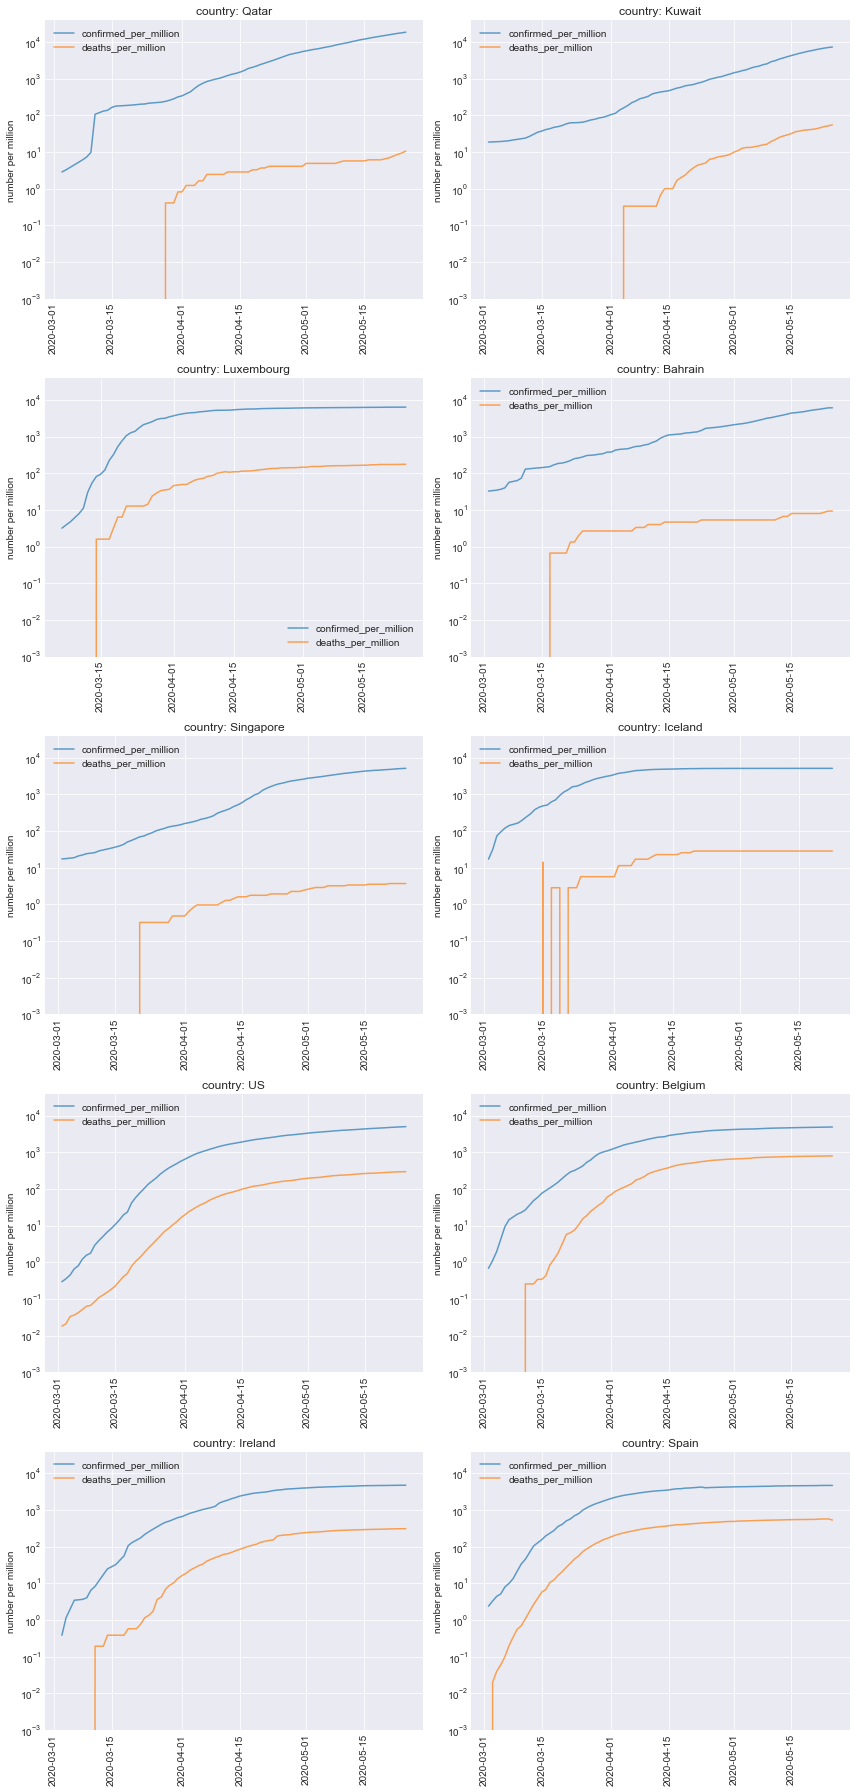

country   population  confirmed   deaths  confirmed_per_million  \
0       Qatar    2444174.0    45465.0     26.0           18601.376170   
1      Kuwait    2993706.0    21967.0    165.0            7337.727886   
2  Luxembourg     628381.0     3993.0    110.0            6354.425102   
3     Bahrain    1505003.0     9171.0     14.0            6093.675561   
4   Singapore    6209660.0    31960.0     23.0            5146.819633   
5     Iceland     350734.0     1804.0     10.0            5143.499062   
6          US  332639102.0  1662302.0  98220.0            4997.313876   
7     Belgium   11720716.0    57342.0   9312.0            4892.363231   
8     Ireland    5176569.0    24698.0   1606.0            4771.113840   
9       Spain   50015792.0   235400.0  26834.0            4706.513495   

   deaths_per_million  mortality_rate  
0           10.637541        0.000572  
1           55.115633        0.007511  
2          175.053033        0.027548  
3            9.302307        0.001527  
4            3.703906        0.000720  
5           28.511636        0.005543  
6          295.274967        0.059087  
7          794.490712        0.162394  
8          310.244102        0.065026  
9          536.510549        0.113993

In [96]:
n_countries = 10
dfp_country_pop_top = (dfp_country_pop[(dfp_country_pop['date'] == dfp_country_pop['date'].max()) &
                                       (dfp_country_pop['pop'] >= 1E5)
                                      ].
                       sort_values(by='confirmed_per_million', ascending=0).
                       reset_index(drop=True)
                      )

plot_countries(dfp_country_pop, 
               countries=dfp_country_pop_top.iloc[:n_countries]['country'],
               plot_cols=['confirmed_per_million', 'deaths_per_million'],
               country_col='country',
               y_max=dfp_country_pop['confirmed_per_million'].max()*2,
               y_min=0.001,
               y_label='number per million',
               date_min=datetime.datetime(2020,3,2)
              )
display_cols = ['country', 'pop', 'confirmed', 'deaths', 'confirmed_per_million', 'deaths_per_million', 'mortality_rate']
display(dfp_country_pop_top[display_cols].rename(columns={'pop': 'population'}).head(10))

In [97]:
dfp_country_pop_top[display_cols].sort_values(by='deaths_per_million', ascending=0).head(10)

country          pop  confirmed   deaths  confirmed_per_million  \
7          Belgium   11720716.0    57342.0   9312.0            4892.363231   
11  United Kingdom   65761117.0   262547.0  36996.0            3992.435226   
9            Spain   50015792.0   235400.0  26834.0            4706.513495   
14           Italy   62402659.0   230158.0  32877.0            3688.272322   
21          France   67848156.0   183067.0  28460.0            2698.186816   
17          Sweden   10202491.0    33843.0   4029.0            3317.131081   
23     Netherlands   17280397.0    45647.0   5849.0            2641.548108   
8          Ireland    5176569.0    24698.0   1606.0            4771.113840   
6               US  332639102.0  1662302.0  98220.0            4997.313876   
15     Switzerland    8403994.0    30746.0   1913.0            3658.498566   

    deaths_per_million  mortality_rate  
7           794.490712        0.162394  
11          562.581685        0.140912  
9           536.510549        0.113993  
14          526.852550        0.142845  
21          419.466080        0.155462  
17          394.903558        0.119050  
23          338.476020        0.128135  
8           310.244102        0.065026  
6           295.274967        0.059087  
15          227.629863        0.062219

### Mortality rate by deaths per capita, confirmed per capita

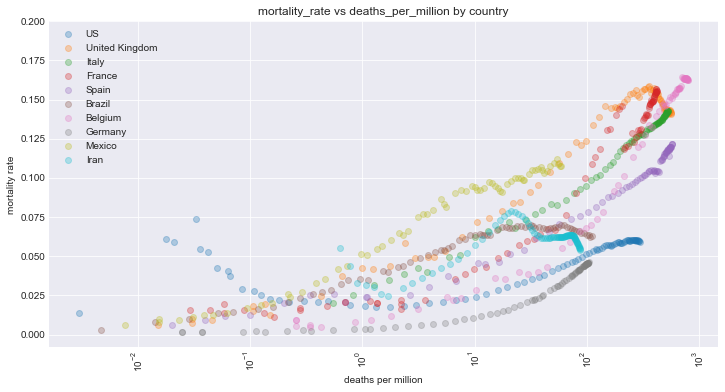

In [98]:
plot_mortality_rate_vs_infections(dfp_country_pop, 
                                  countries, 
                                  upper_lim=0.2, 
                                  id_col='country', 
                                  date_min=datetime.datetime(2020,3,1), 
                                  x_col='deaths_per_million', 
                                  y_col='mortality_rate'
                                 )

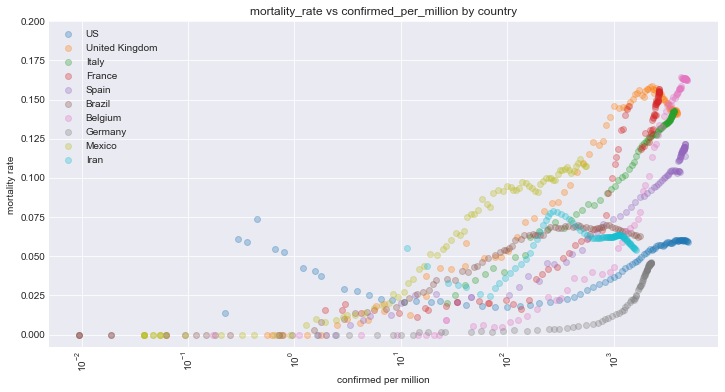

In [99]:
plot_mortality_rate_vs_infections(dfp_country_pop, 
                                  countries, 
                                  upper_lim=0.2, 
                                  id_col='country', 
                                  date_min=datetime.datetime(2020,3,1), 
                                  x_col='confirmed_per_million', 
                                  y_col='mortality_rate'
                                 )

<a id='days_behind'></a>
# How many days behind is each country from Italy?

In [100]:
def days_behind_multi_country(
    countries_compare, 
    country_base, 
    dfp=dfp_country_pop, 
    n_days=14, 
    country_col='country',
    compare_col='confirmed_frac'
):
#     country_compare = 'Spain'
#     country_base = 'Italy'
    countries = [country_base] + countries_compare
    #n_days = 14  # compare the lag over the last n_days

    # compare the fraction of cases directly
    list_dfp_compare = []
    d_dfp_compare = {}

    for i, country in enumerate(countries):
        dfp_p = dfp[dfp[country_col] == country]
        dfp_p = dfp_p.sort_values(by='date', ascending=0).reset_index(drop=True)
        
        if country == country_base:
            line_style = '-'
            dfp_comp = dfp_p.copy()
            alpha=1
        else:
            line_style = '--'
            list_dfp_compare.append(dfp_p)
            d_dfp_compare[country] = dfp_p
            alpha=0.7
        
        plt.plot(dfp_p['date'], dfp_p['confirmed'], linestyle=line_style, alpha=alpha, label=country)
        
    plt.legend(loc='best')
    plt.title('Raw number of cases')
    plt.ylabel('cases')
    plt.yscale('log')
    plt.show()


    # compute the best estimate of the lag between countries
    # this assumes that the best metric is density of cases
    # though this may be more dependent on localities
    metric = compare_col
    delta_col = f'delta_{metric}'
    list_series = []

    for country, dfp_test in d_dfp_compare.items():
        list_series = []
        delta_col = f'delta_{metric}_{country}'
        for i, row in dfp_test[:n_days].iterrows():
            dfp_comp[delta_col] = np.abs(dfp_comp[metric] - row[metric])
            min_loc = dfp_comp[delta_col] == dfp_comp[delta_col].min()
            #print(row['date'] - dfp_comp[min_loc]['date'])
            days_diff = pd.to_timedelta(row['date'] - dfp_comp[min_loc]['date']).astype('timedelta64[D]').values[0]
            row['days_diff'] = days_diff
            row['country_compare'] = country
            list_series.append(row)

        # plot days behind
        dfp_days_behind = pd.concat(list_series, axis=1).T
        plt.plot(dfp_days_behind['date'], dfp_days_behind['days_diff'], label=country, alpha=0.5)
        mean_days_diff = dfp_days_behind['days_diff'].mean()#{str(dfp['date'].max())}
        date_max = dfp['date'].max().strftime('%Y-%m-%d')
    plt.axhline(0, label='0', color='k', linestyle='--', alpha=0.5)
    #print(f'Computing how far behind a country is using the {compare_col} column:')
    plt.title(f'Number days each {country_col} is from {country_base} as of {date_max} using {compare_col}')
    plt.ylabel('# days')
    plt.legend(loc='best')
    plt.show()
    return dfp_days_behind

##### Days behind Italy via density of cases

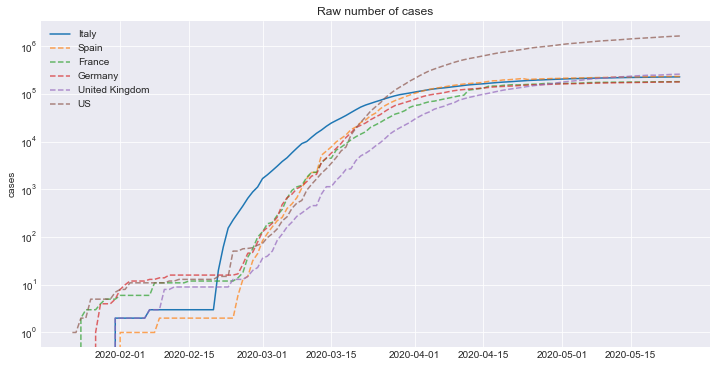

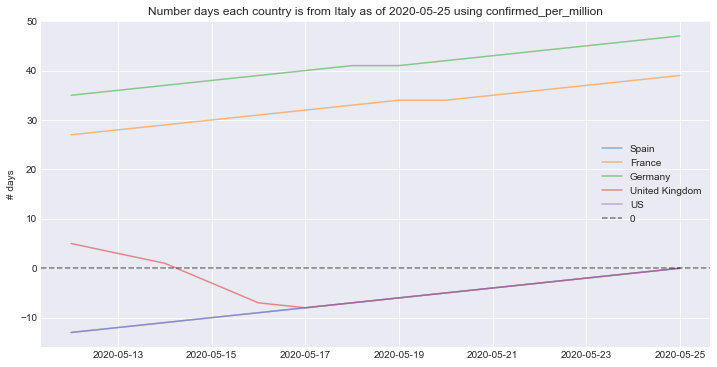

In [101]:
_ = days_behind_multi_country(['Spain', 'France', 'Germany', 'United Kingdom', 'US'], 'Italy', dfp=dfp_country_pop, compare_col='confirmed_per_million')

##### Days behind Italy via number of confirmed cases

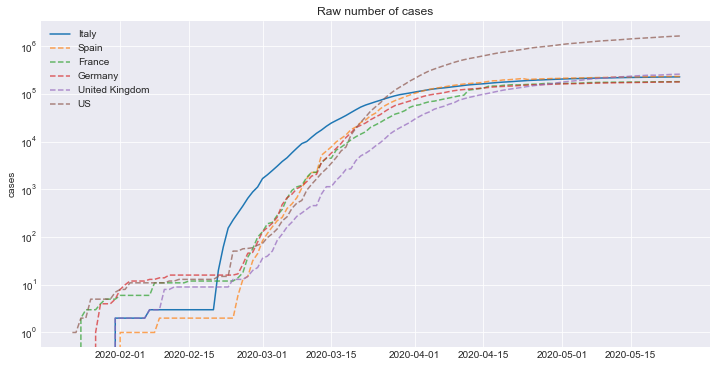

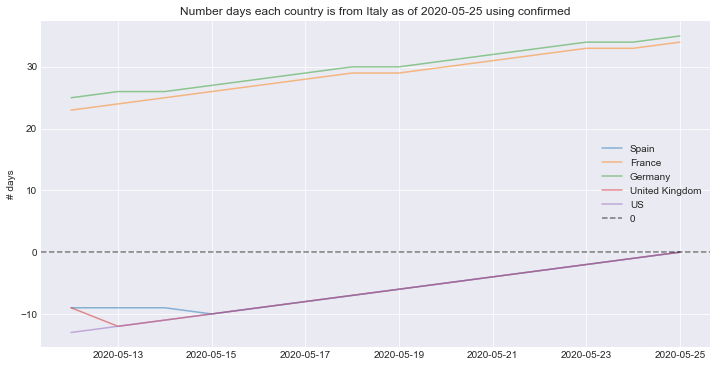

In [102]:
_ = days_behind_multi_country(['Spain', 'France', 'Germany', 'United Kingdom', 'US'], 'Italy', dfp=dfp_country_pop, compare_col='confirmed')

# US state breakdown

In [103]:
# load and clean data
dfp_us_raw = pd.read_csv('state_data/states-daily.csv')
dfp_us_raw = dfp_us_raw.rename(columns={'state': 'state_clean_1',
                                        'positive': 'confirmed',
                                        'death': 'deaths',
                                        'date': 'date_str'
                                       })
dfp_us_raw['date'] = dfp_us_raw['date_str'].apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))
dfp_us_raw['country'] = 'US'

In [104]:
# load and clean data from CSSEGIS
state_base_dir = '../COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/'
data_paths_raw = os.listdir(state_base_dir)
data_paths = [path for path in data_paths_raw if path.endswith('csv')]
list_dfp_states = []
cols_of_interest = ['country', 'state', 'date', 'confirmed', 'deaths', 'recovered']
for path in data_paths:
    full_path = os.path.join(state_base_dir, path)
    
    # read state data
    dfp_temp = pd.read_csv(full_path)
    cols = list(dfp_temp.columns)
    
    # clean column names
    cols_translate = {'Country/Region': 'country',
                      'Province/State': 'state',
                      'Confirmed': 'confirmed',
                      'Deaths': 'deaths',
                      'Recovered': 'recovered',
                      'Country_Region': 'country',
                      'Province_State': 'state',
                      'Last_Update': 'Last Update'
                     }
    dfp_temp = dfp_temp.rename(columns=cols_translate)
    dfp_temp['date'] = dfp_temp['Last Update'].apply(lambda x: parser.parse(x).date())
    dfp_temp['date'] = dfp_temp['date'].apply(lambda x: datetime.datetime(x.year, x.month, x.day))
    dfp_temp = dfp_temp[dfp_temp['country'] == 'US']
    list_dfp_states.append(dfp_temp[cols_of_interest])
dfp_us_raw = pd.concat(list_dfp_states)
dfp_us_raw['state_clean_1'] = dfp_us_raw['state'].apply(lambda x: re.findall('\, ([A-Z]{2}$)', x)[0].strip() if re.findall('\, ([A-Z]{2}$)', x) else x)

In [105]:
# look only at the US
#dfp_us_raw = dfp[dfp['country'] == 'US'].copy()
#dfp_us_raw['state_clean_1'] = dfp_us_raw['state'].apply(lambda x: re.findall('\, ([A-Z]{2})', x)[0].strip() if re.findall('\, ([A-Z]{2})', x) else x)

# load codes to convert two-letter codes to state names
dfp_state_codes = pd.read_csv('supporting_data/us_state_to_two_letter_code.csv')
dfp_state_codes = dfp_state_codes.rename(columns={'state': 'state_name'})
dfp_us = dfp_us_raw.merge(dfp_state_codes, left_on=['state_clean_1'], right_on=['two_letter_code'], how='left')

In [106]:
# get the most appropriate state name
dfp_us['abbrev'] = ~dfp_us['state_name'].isnull()
dfp_us['state_clean'] = dfp_us.apply(lambda x: x['state_name'] if x['abbrev'] else x['state_clean_1'], axis=1)

# aggregate infections by state
dfp_us_g = (dfp_us.groupby(['date', 'country', 'state_clean'], as_index=False).
            agg({
                'confirmed': np.sum,
                'deaths': np.sum,
                #'recovered': np.sum,
               })
           )
dfp_us_g = dfp_us_g.sort_values(by='date')
dfp_us_g = dfp_us_g.rename(columns={'state_clean': 'state'})
#dfp_us_g['active'] = dfp_us_g['confirmed'] - dfp_us_g['recovered']
dfp_us_g['confirmed_lag1'] = dfp_us_g.groupby(['country', 'state'])['confirmed'].shift(1)
dfp_us_g['deaths_lag1'] = dfp_us_g.groupby(['country', 'state'])['deaths'].shift(1)
dfp_us_g['confirmed_new'] = dfp_us_g['confirmed'] - dfp_us_g['confirmed_lag1']
dfp_us_g['deaths_new'] = dfp_us_g['deaths'] - dfp_us_g['deaths_lag1']
dfp_us_g['deaths_new'] = dfp_us_g['deaths_new'].fillna(0)
dfp_us_g['mortality_rate'] = dfp_us_g['deaths'] / dfp_us_g['confirmed']

<a id='states_most_infections'></a>
### US states with the most new infections

In [107]:
id_cols_state = ['date', 'state']
value_cols_state = ['confirmed', 'confirmed_new', 'deaths', 'deaths_new', 'mortality_rate']

dfp_us_top_states = dfp_us_g[dfp_us_g['date'] == dfp_us_g['date'].max()][id_cols_state + value_cols_state]
dfp_us_top_states = dfp_us_top_states.sort_values(by='deaths', ascending=0).reset_index(drop=True)
dfp_us_top_states = dfp_us_top_states.fillna(0)
for key in value_cols_state:
    if 'rate' in key:
        continue
    dfp_us_top_states[key] = dfp_us_top_states[key].apply(int)
dfp_us_top_states.head(15)

date          state  confirmed  confirmed_new  deaths  deaths_new  \
0  2020-05-26       New York     362764           1249   29229          88   
1  2020-05-26     New Jersey     155092            938   11147           9   
2  2020-05-26  Massachusetts      93271            596    6416          44   
3  2020-05-26       Michigan      54881            202    5241          13   
4  2020-05-26   Pennsylvania      71925            362    5146          10   
5  2020-05-26       Illinois     112017           1713    4885          29   
6  2020-05-26     California      96400           2380    3769          15   
7  2020-05-26    Connecticut      40873            405    3742          49   
8  2020-05-26      Louisiana      37809            640    2691           0   
9  2020-05-26       Maryland      47152            839    2302          25   
10 2020-05-26        Florida      51746            879    2252          15   
11 2020-05-26           Ohio      32477            566    1987          18   
12 2020-05-26        Indiana      31715            339    1984           8   
13 2020-05-26        Georgia      43400            498    1848          21   
14 2020-05-26          Texas      56409            548    1533           5   

    mortality_rate  
0         0.080573  
1         0.071873  
2         0.068789  
3         0.095498  
4         0.071547  
5         0.043609  
6         0.039098  
7         0.091552  
8         0.071174  
9         0.048821  
10        0.043520  
11        0.061182  
12        0.062557  
13        0.042581  
14        0.027177

<a id='time-series_states'></a>
### Time-series plots of infections in most-infected states

In [108]:
def plot_state_data(dfp_us_g, states_oi, plot_col='confirmed', date_min=datetime.datetime(2020, 2, 25)):
    for state in states_oi:
        dfp_s = dfp_us_g[(dfp_us_g['state'] == state) & (dfp_us_g['date'] >= date_min)]
        plt.plot(dfp_s['date'], dfp_s[plot_col], label=state, alpha=0.5)
    plt.ylabel('# cases')
    plt.xticks(rotation=90)
    plt.title(f'{plot_col} in: {", ".join(states_oi)}')
    plt.yscale('log')
    plt.legend(loc='best')
    plt.show()
    return None

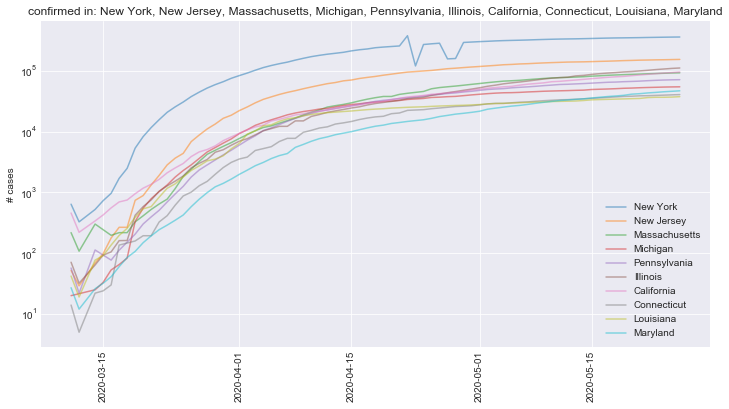

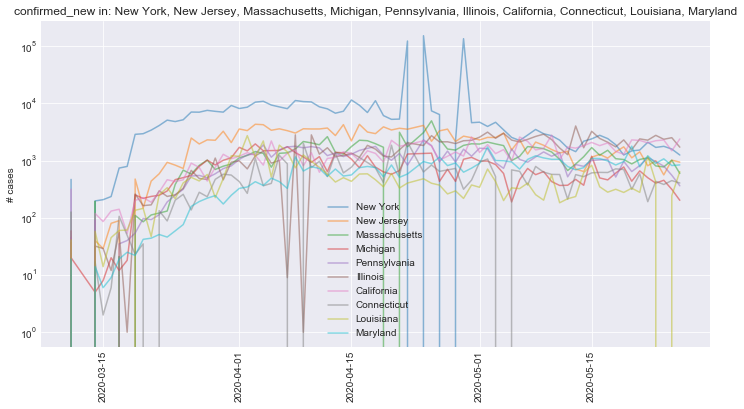

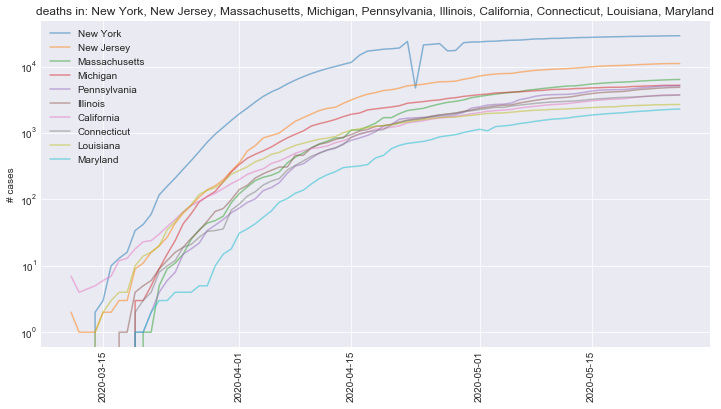

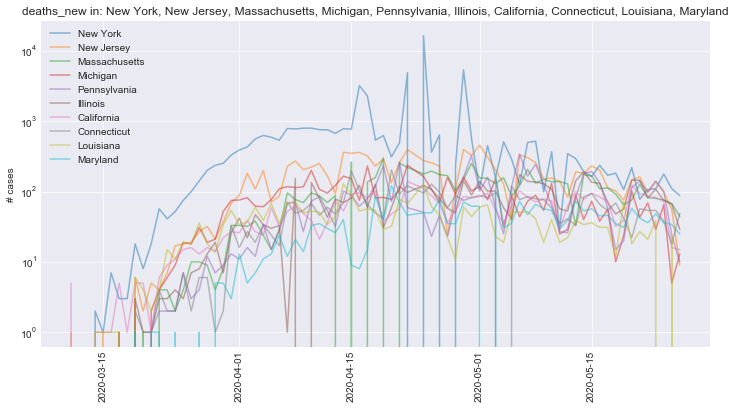

In [109]:
states_oi = dfp_us_top_states.iloc[:10]['state'].values
dt_min = datetime.datetime(2020,3,11)
plot_state_data(dfp_us_g, states_oi, plot_col='confirmed', date_min=dt_min)
plot_state_data(dfp_us_g, states_oi, plot_col='confirmed_new', date_min=dt_min)
plot_state_data(dfp_us_g, states_oi, plot_col='deaths', date_min=dt_min)
plot_state_data(dfp_us_g, states_oi, plot_col='deaths_new', date_min=dt_min)

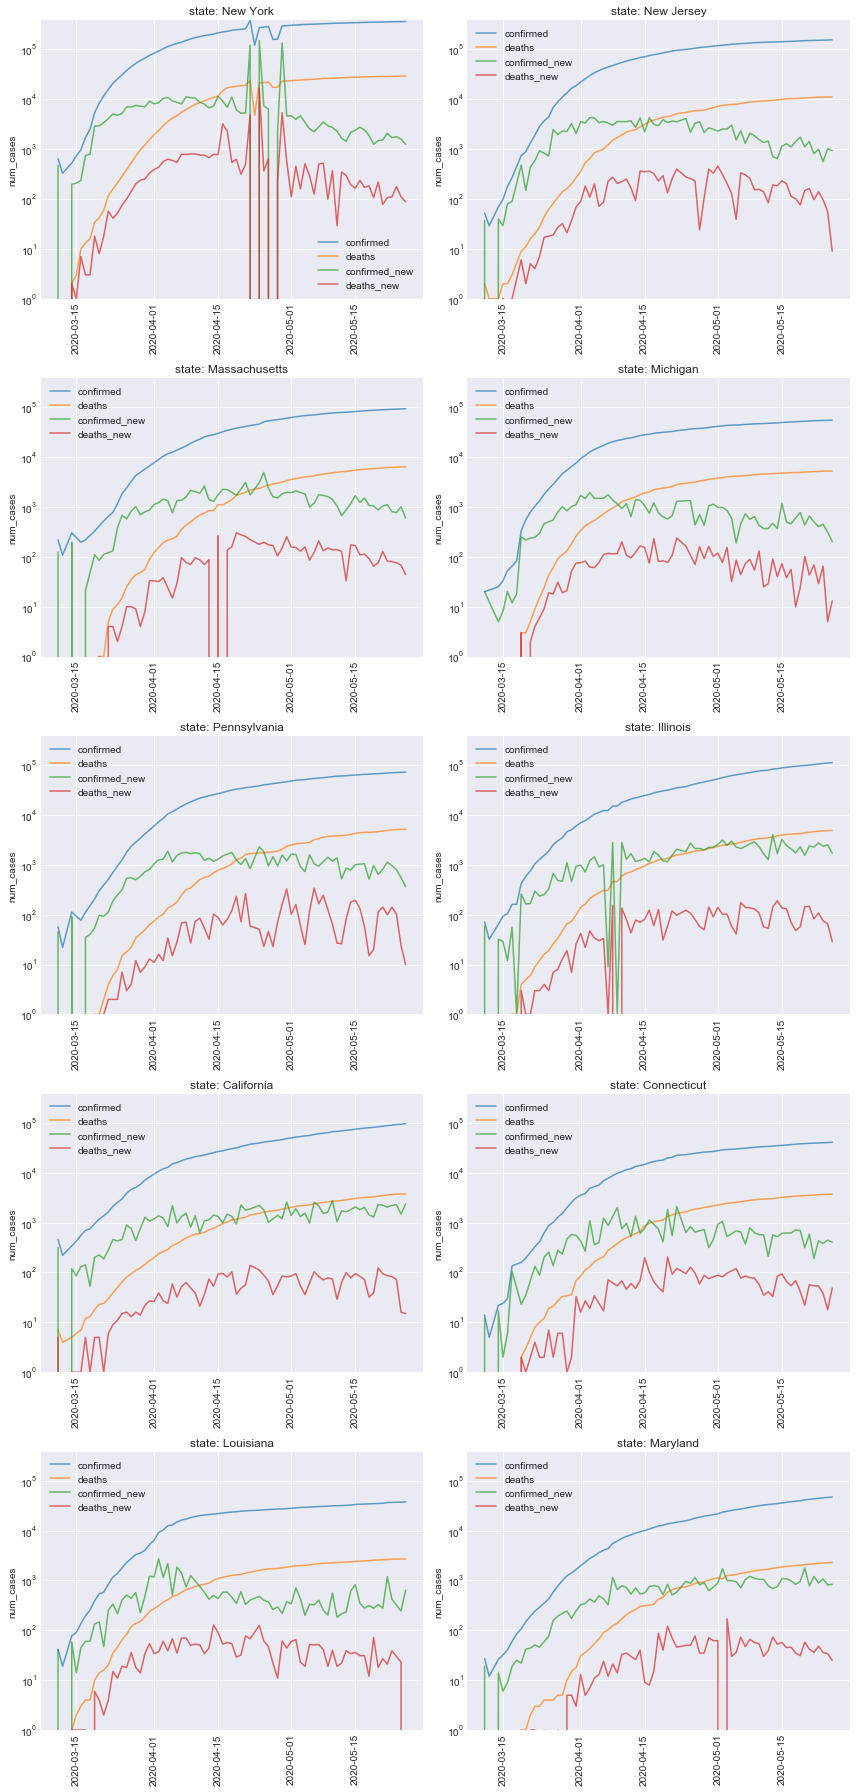

In [110]:
plot_countries(dfp_us_g, 
               countries=dfp_us_top_states.iloc[:10]['state'].values,
               plot_cols=['confirmed', 'deaths', 'confirmed_new', 'deaths_new'], #, 'recovered', 'active'
               country_col='state',
               date_min=datetime.datetime(2020,3,11),
               y_max=dfp_us_g['confirmed'].max()
              )

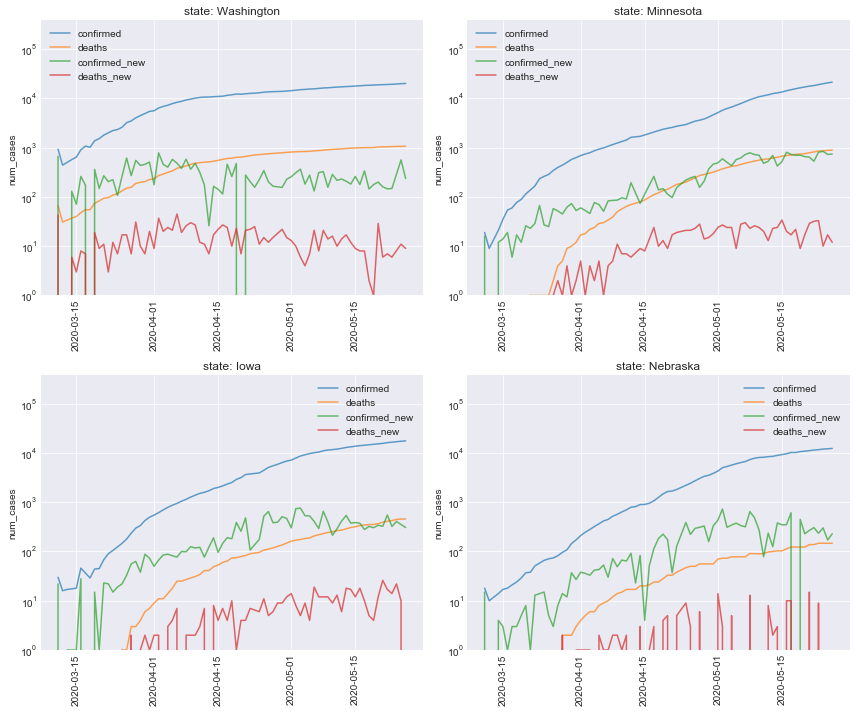

In [111]:
plot_countries(dfp_us_g, 
               countries=['Washington', 'Minnesota', 'Iowa', 'Nebraska'],
               plot_cols=['confirmed', 'deaths', 'confirmed_new', 'deaths_new'], #, 'recovered', 'active'
               country_col='state',
               date_min=datetime.datetime(2020,3,11),
               y_max=dfp_us_g['confirmed'].max()
              )

<a id='forecast_us_state'></a>
### Forecast by state

##### 1 week of data

confirmed_pred                       deaths_pred             \
date              2020-05-27 2020-06-02 2020-06-16  2020-05-27 2020-06-02   
state                                                                       
New York            364843.0   375373.0   401139.0     29360.0    30090.0   
New Jersey          156063.0   161769.0   175907.0     11324.0    11940.0   
Massachusetts        94415.0   100168.0   114993.0      6531.0     7049.0   
Pennsylvania         73189.0    78424.0    92141.0      5327.0     5948.0   
Michigan             55522.0    58197.0    64949.0      5310.0     5560.0   
Illinois            115140.0   131965.0   181413.0      5028.0     5607.0   
California           98809.0   113583.0   157224.0      3891.0     4322.0   
Connecticut          41266.0    43804.0    50348.0      3798.0     4085.0   
Louisiana            38343.0    41259.0    48956.0      2725.0     2846.0   
Maryland             48353.0    55035.0    74440.0      2353.0     2609.0   

                         mortality_rate_pred                        \
date          2020-06-16          2020-05-27 2020-06-02 2020-06-16   
state                                                                
New York         31864.0            0.080473   0.080160   0.079434   
New Jersey       13512.0            0.072560   0.073809   0.076813   
Massachusetts     8421.0            0.069173   0.070372   0.073231   
Pennsylvania      7694.0            0.072784   0.075844   0.083502   
Michigan          6189.0            0.095638   0.095538   0.095290   
Illinois          7229.0            0.043669   0.042489   0.039848   
California        5524.0            0.039379   0.038051   0.035135   
Connecticut       4845.0            0.092037   0.093256   0.096230   
Louisiana         3149.0            0.071069   0.068979   0.064323   
Maryland          3318.0            0.048663   0.047406   0.044573   

              frac_increase_confirmed frac_increase_deaths  
date                                                        
state                                                       
New York                     0.004753             0.004101  
New Jersey                   0.006003             0.008870  
Massachusetts                0.009907             0.012787  
Pennsylvania                 0.011581             0.018557  
Michigan                     0.007871             0.007691  
Illinois                     0.022992             0.018316  
California                   0.023496             0.017677  
Connecticut                  0.009995             0.012248  
Louisiana                    0.012292             0.007262  
Maryland                     0.021807             0.017328

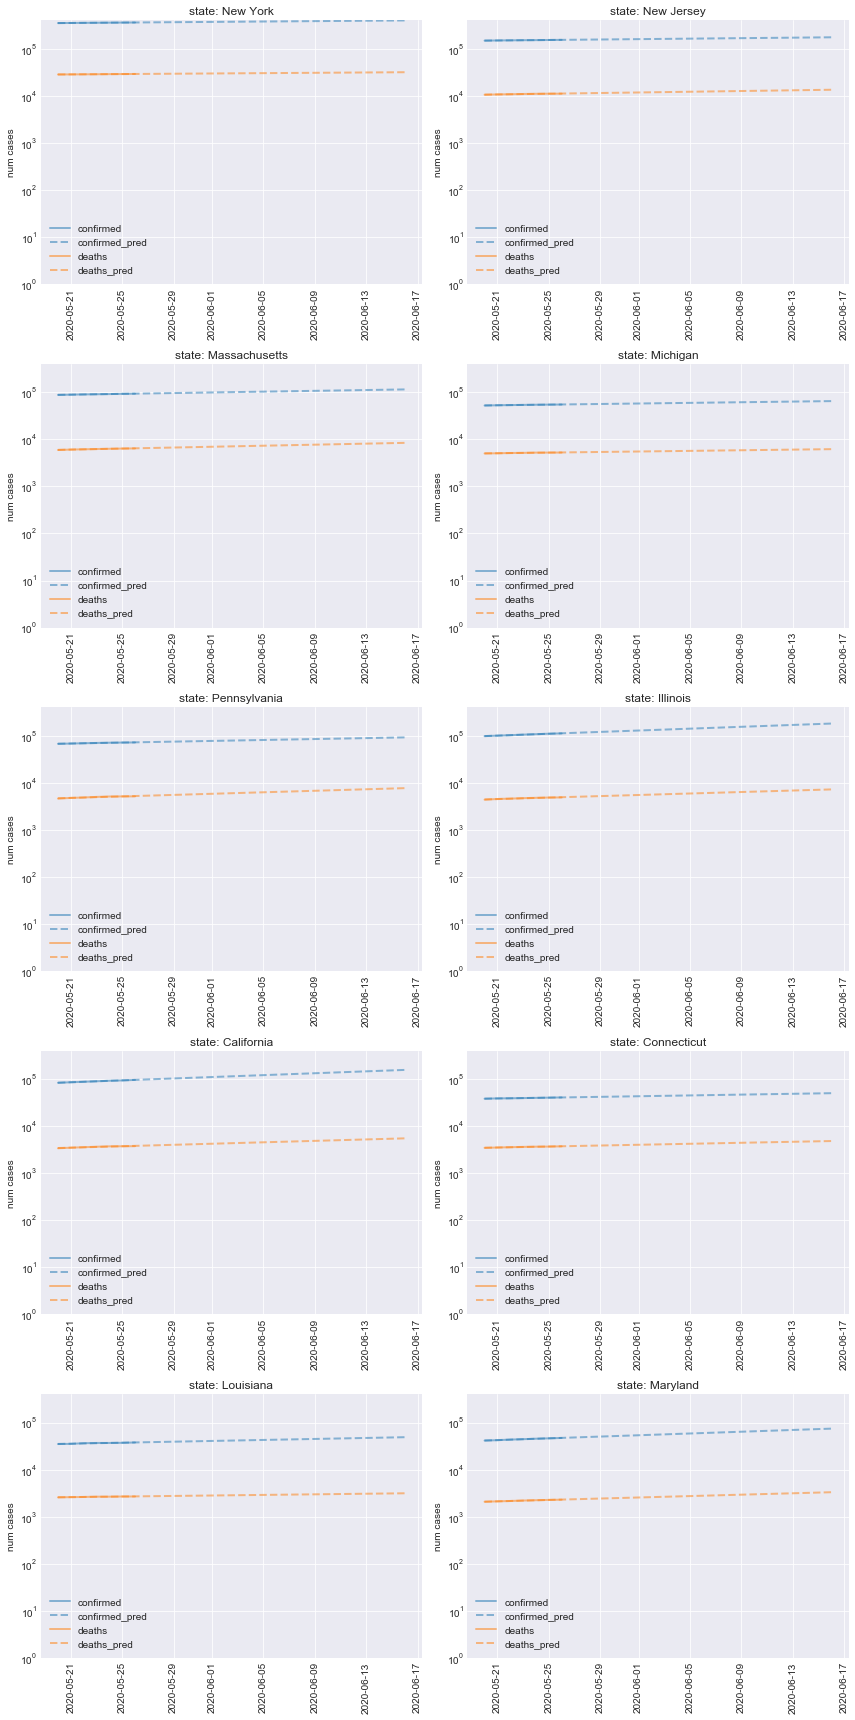

In [112]:
dfp_state_recent_1, dfp_state_forecasts_out_1 = fit_exp(dfp_us_g, 
                                                    n_days_predict=7,
                                                    n_days_into_future=[1,7,21],
                                                    col_locale='state', 
                                                    top_countries=None
                                                   )
plot_forecasts(dfp_state_recent_1, 
                   n_countries=10, 
                   n_columns=2, 
                   figsize=(12,24), 
                   date_min=datetime.datetime(2020, 2, 1),
                   col_locale='state',
                  )

##### 2 weeks of data

confirmed_pred                       deaths_pred             \
date              2020-05-27 2020-06-02 2020-06-16  2020-05-27 2020-06-02   
state                                                                       
New York            365739.0   377444.0   406233.0     29499.0    30447.0   
New Jersey          157087.0   164588.0   183513.0     11471.0    12329.0   
Massachusetts        95430.0   102801.0   122292.0      6633.0     7313.0   
Pennsylvania         73536.0    79331.0    94692.0      5368.0     6055.0   
Michigan             56128.0    59816.0    69393.0      5339.0     5646.0   
Illinois            115396.0   132438.0   182641.0      5117.0     5865.0   
California           98865.0   113752.0   157799.0      3948.0     4496.0   
Connecticut          41862.0    45380.0    54781.0      3850.0     4217.0   
Louisiana            38341.0    41217.0    48793.0      2765.0     2956.0   
Maryland             49084.0    57325.0    82342.0      2386.0     2702.0   

                         mortality_rate_pred                        \
date          2020-06-16          2020-05-27 2020-06-02 2020-06-16   
state                                                                
New York         32777.0            0.080656   0.080666   0.080685   
New Jersey       14590.0            0.073023   0.074908   0.079504   
Massachusetts     9186.0            0.069506   0.071137   0.075115   
Pennsylvania      8018.0            0.072998   0.076326   0.084675   
Michigan          6435.0            0.095122   0.094389   0.092733   
Illinois          8062.0            0.044343   0.044285   0.044141   
California        6090.0            0.039933   0.039525   0.038593   
Connecticut       5214.0            0.091969   0.092926   0.095179   
Louisiana         3453.0            0.072116   0.071718   0.070768   
Maryland          3611.0            0.048611   0.047135   0.043854   

              frac_increase_confirmed frac_increase_deaths  
date                                                        
state                                                       
New York                     0.005264             0.005281  
New Jersey                   0.007805             0.012094  
Massachusetts                0.012478             0.016418  
Pennsylvania                 0.012723             0.020262  
Michigan                     0.010664             0.009382  
Illinois                     0.023223             0.022987  
California                   0.023654             0.021915  
Connecticut                  0.013539             0.015285  
Louisiana                    0.012126             0.011171  
Maryland                     0.026205             0.020931

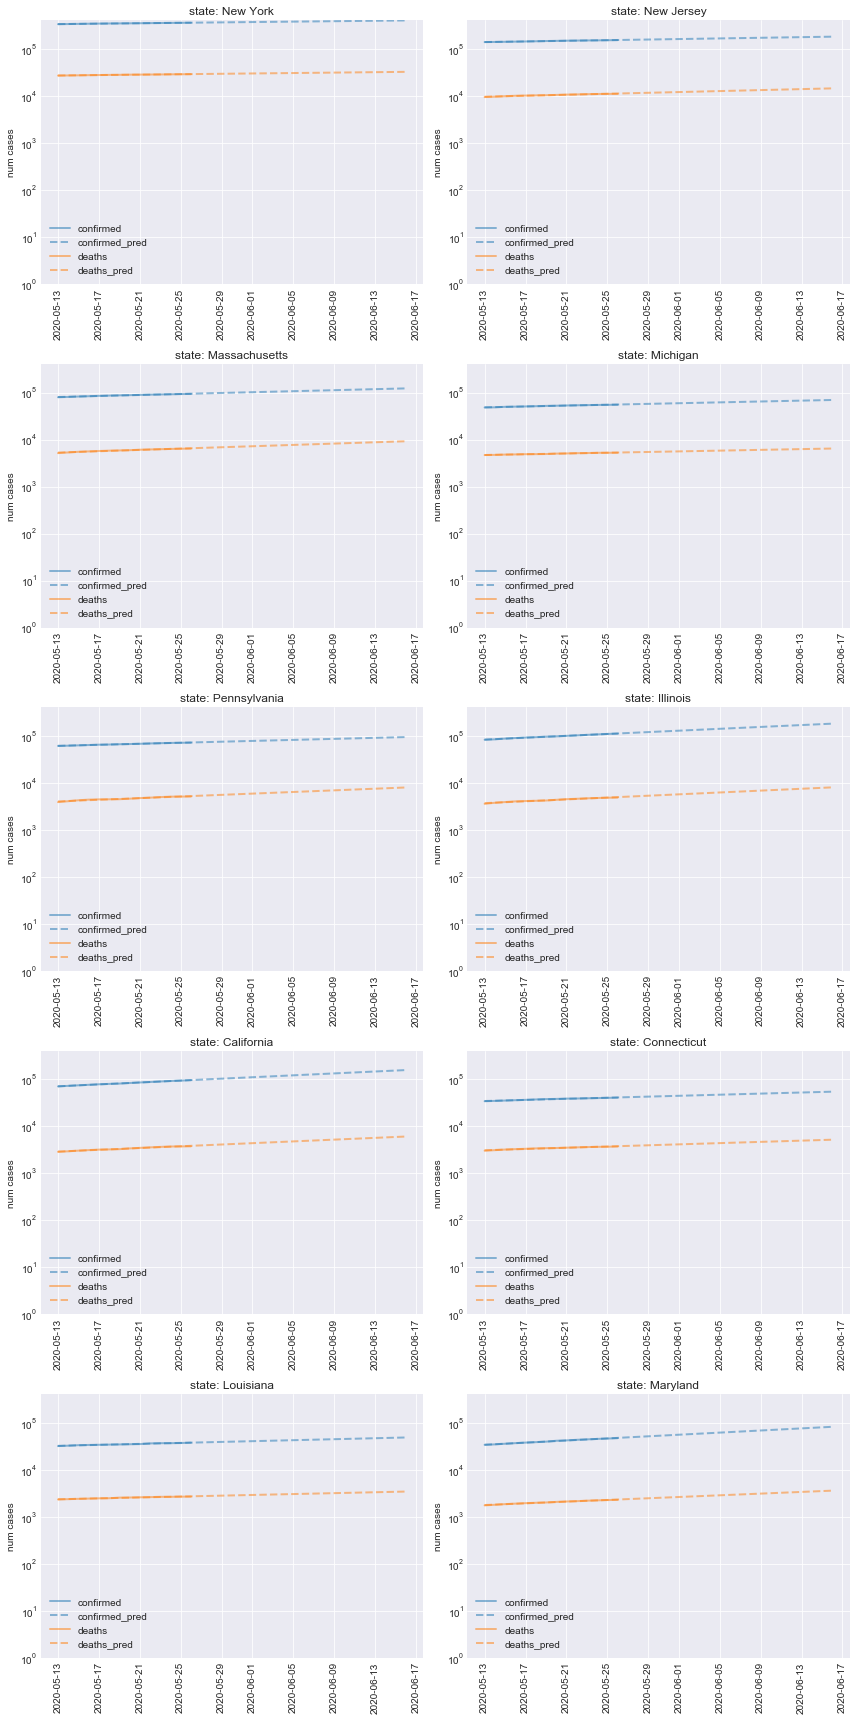

In [113]:
dfp_state_recent_2, dfp_state_forecasts_out_2 = fit_exp(dfp_us_g, 
                                                    n_days_predict=14,
                                                    n_days_into_future=[1,7,21],
                                                    col_locale='state', 
                                                    top_countries=None
                                                   )
plot_forecasts(dfp_state_recent_2, 
                   n_countries=10, 
                   n_columns=2, 
                   figsize=(12,24), 
                   date_min=datetime.datetime(2020, 2, 1),
                   col_locale='state',
                  )

<a id='us_state_daily_increase_fraction'></a>
##### States and their daily increase fraction in confirmed cases/deaths
Computed via linear fit of the log of the confirmed cases/deaths over the last 7 days.

In [114]:
# increase_cols = ['state', 'frac_increase_confirmed', 'frac_increase_deaths']
# curr_cols = ['date', 'state', 'confirmed', 'deaths']
# dfp_state_increase_m = dfp_us_g_latest[curr_cols].merge(dfp_state_increase[increase_cols], on=['state'], how='inner')
# for col in ['confirmed', 'deaths']:
#     dfp_state_increase_m[col] = dfp_state_increase_m[col].apply(int)

In [115]:
# latest date
dt_latest = dfp_us_g['date'].max()
dfp_us_g_date_max = dfp_us_g.groupby(['state'], as_index=False).agg({'date': np.max})
#dfp_us_g_latest = dfp_us_g[dfp_us_g['date'] == dt_latest].copy()
dfp_us_g_latest = dfp_us_g.merge(dfp_us_g_date_max, on=['state', 'date'], how='inner')

# what is the distribution in % increase in deaths?
dfp_state_increase = (dfp_state_forecasts_out_1[(dfp_state_forecasts_out_1['date'] == dfp_state_forecasts_out_1['date'].max()) &
                                                (dfp_state_forecasts_out_1['deaths_pred'] > 2)
                                               ].
                      sort_values(by='frac_increase_deaths', ascending=0).
                      reset_index(drop=True)
                     )
increase_cols = ['state', 'frac_increase_confirmed', 'frac_increase_deaths']
curr_cols = ['date', 'state']
int_cols = ['confirmed', 'deaths', 'deaths_new']
float_cols = ['frac_increase_confirmed', 'frac_increase_deaths']
dfp_state_increase_m = dfp_us_g_latest[curr_cols + int_cols].merge(dfp_state_increase[increase_cols], on=['state'], how='inner')
for col in int_cols:
    dfp_state_increase_m[col] = dfp_state_increase_m[col].apply(int)
for col in float_cols:
    dfp_state_increase_m[col] = dfp_state_increase_m[col].apply(lambda x: np.round(float(x),3))
(dfp_state_increase_m[curr_cols + int_cols + float_cols].
 sort_values(by='frac_increase_deaths', ascending=0).
 reset_index(drop=True)
)


date                 state  confirmed  deaths  deaths_new  \
0  2020-05-26                  Iowa      17557     456           0   
1  2020-05-26         New Hampshire       4197     210           1   
2  2020-05-26             Minnesota      21315     890          12   
3  2020-05-26          Rhode Island      14065     608           0   
4  2020-05-26              Nebraska      12362     147           0   
5  2020-05-26               Wyoming        843      12           0   
6  2020-05-26          North Dakota       2457      54           1   
7  2020-05-26            New Mexico       7026     320           3   
8  2020-05-26                  Ohio      32477    1987          18   
9  2020-05-26           Mississippi      13458     635          10   
10 2020-05-26              Virginia      37727    1208          37   
11 2020-05-26              Arkansas       6029     117           1   
12 2020-05-26        North Carolina      24057     790           6   
13 2020-05-26               Arizona      16575     807           6   
14 2020-05-26             Tennessee      20535     338           2   
15 2020-05-26          Pennsylvania      71925    5146          10   
16 2020-05-26                  Utah       8521      98           1   
17 2020-05-26              Illinois     112017    4885          29   
18 2020-05-26               Alabama      14986     566          15   
19 2020-05-26            California      96400    3769          15   
20 2020-05-26              Maryland      47152    2302          25   
21 2020-05-26               Georgia      43400    1848          21   
22 2020-05-26                 Texas      56409    1533           5   
23 2020-05-26          South Dakota       4586      50           0   
24 2020-05-26               Florida      51746    2252          15   
25 2020-05-26        South Carolina      10178     440           5   
26 2020-05-26  District of Columbia       8225     440           8   
27 2020-05-26             Wisconsin      15584     514           4   
28 2020-05-26              Missouri      12476     689           3   
29 2020-05-26               Indiana      31715    1984           8   
30 2020-05-26                 Maine       2074      78           0   
31 2020-05-26              Delaware       8965     332           6   
32 2020-05-26         Massachusetts      93271    6416          44   
33 2020-05-26           Connecticut      40873    3742          49   
34 2020-05-26              Oklahoma       6090     313           2   
35 2020-05-26                Nevada       7956     394          14   
36 2020-05-26         West Virginia       1774      72           0   
37 2020-05-26                 Idaho       2626      79           0   
38 2020-05-26              Kentucky       8571     391           0   
39 2020-05-26            New Jersey     155092   11147           9   
40 2020-05-26              Colorado      24256    1333           1   
41 2020-05-26                Oregon       3949     148           0   
42 2020-05-26              Michigan      54881    5241          13   
43 2020-05-26             Louisiana      37809    2691           0   
44 2020-05-26           Puerto Rico       3260     129           2   
45 2020-05-26            Washington      20065    1070           9   
46 2020-05-26                Kansas       9125     207           2   
47 2020-05-26              New York     362764   29229          88   
48 2020-05-26                  Guam        166       5           0   
49 2020-05-26        Virgin Islands         69       6           0   
50 2020-05-26               Vermont        962      54           0   
51 2020-05-26               Montana        479      16           0   
52 2020-05-26                Hawaii        643      17           0   
53 2020-05-26        Grand Princess        103       3           0   
54 2020-05-26                Alaska        408      10           0   

    frac_increase_confirmed  frac_increase_deaths  
0                     0.024         

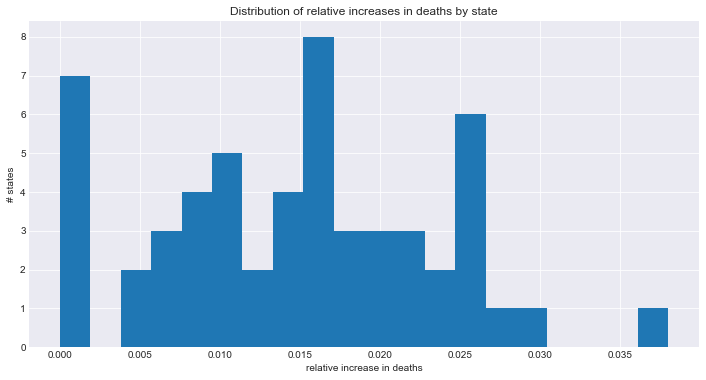

In [116]:
dfp_state_increase_m['frac_increase_deaths'].hist(bins=20)
plt.xlabel('relative increase in deaths')
plt.ylabel('# states')
plt.title('Distribution of relative increases in deaths by state')
plt.show()

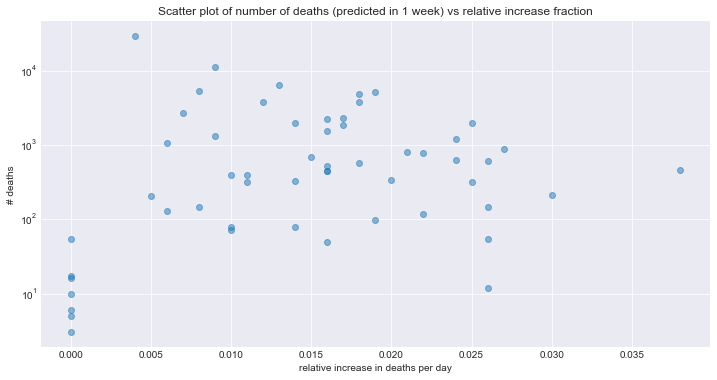

In [117]:
plt.plot(dfp_state_increase_m['frac_increase_deaths'], dfp_state_increase_m['deaths'], 'o', alpha=0.5)
#plt.xscale('log')
plt.yscale('log')
plt.xlabel('relative increase in deaths per day')
plt.ylabel('# deaths')
plt.title('Scatter plot of number of deaths (predicted in 1 week) vs relative increase fraction')
plt.show()

<a id='state_infections_vs_wa'></a>
##### Compare US state infections against Washington

In [118]:
dfp_us_g = dfp_us_g[~(dfp_us_g['date']==datetime.datetime(2020,3,9))]

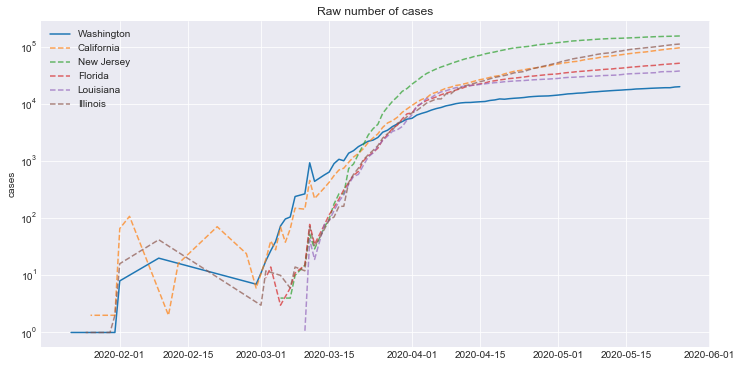

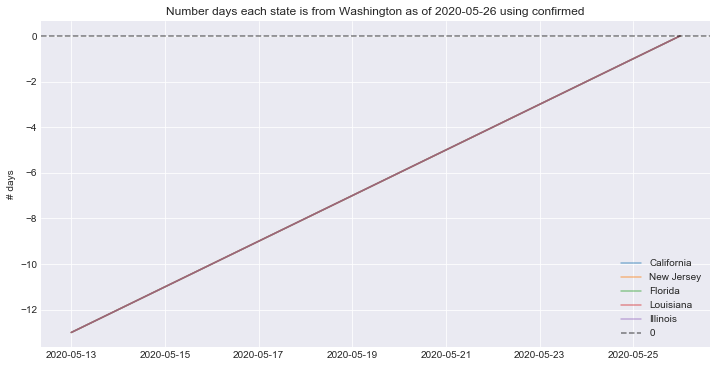

In [119]:
_ = days_behind_multi_country(['California', 'New Jersey', 'Florida', 'Louisiana', 'Illinois'], 
                              'Washington', 
                              dfp=dfp_us_g, 
                              country_col='state', 
                              compare_col='confirmed'
                             )

<a id='state_infections_vs_ny'></a>
##### Compare US state infections against New York

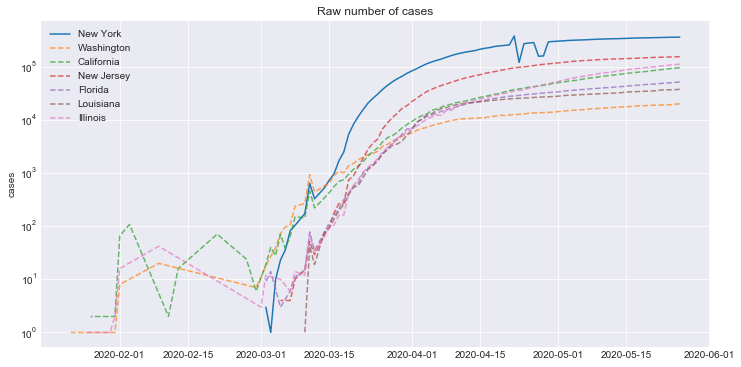

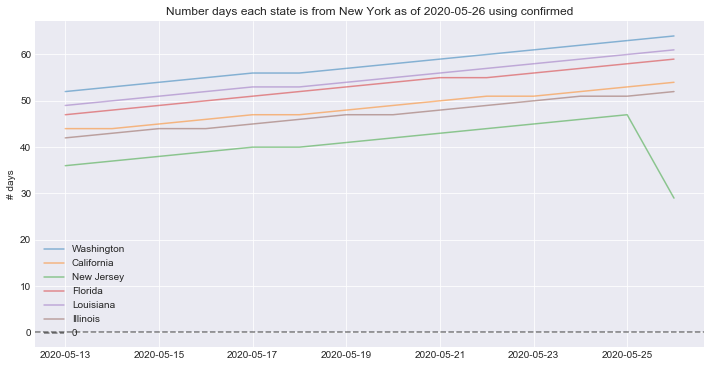

In [120]:
_ = days_behind_multi_country(['Washington', 'California', 'New Jersey', 'Florida', 'Louisiana', 'Illinois'], 
                              'New York', 
                              dfp=dfp_us_g, 
                              country_col='state', 
                              compare_col='confirmed'
                             )

<a id='mortality_by_us_state'></a>
### Mortality rate by US state

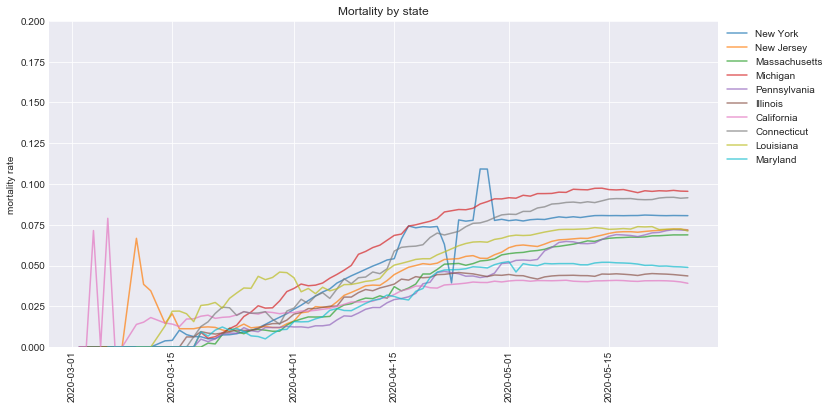

In [121]:
n_states = 10
states = dfp_us_top_states.iloc[:n_states]['state']

plot_mortality_rate(dfp_us_g, states, upper_lim=0.2, id_col='state', date_min=datetime.datetime(2020,3,2))

##### Relationship between mortality rate and number of cases

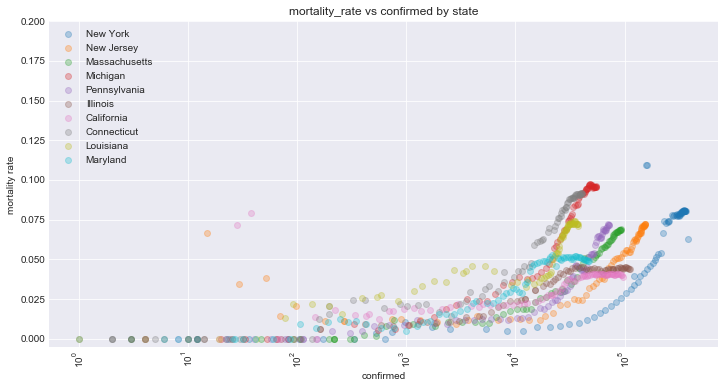

In [122]:
plot_mortality_rate_vs_infections(dfp_us_g, states, upper_lim=0.2, id_col='state', date_min=datetime.datetime(2020,3,1))

<a id='us_state_relative_increases'></a>
### Relative increases per day by state

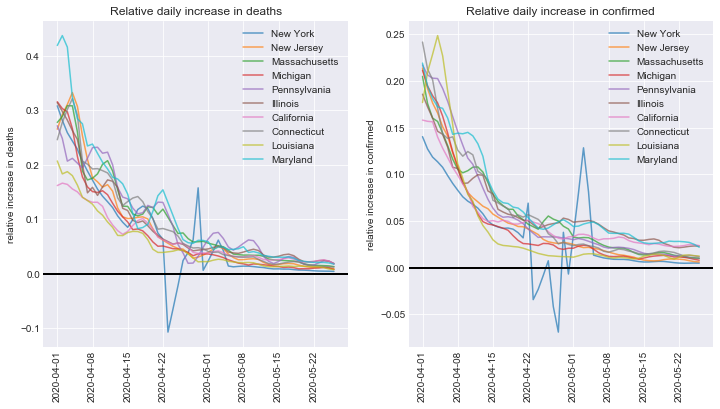

In [123]:
find_relative_increase_data_and_plot(dfp_us_g, n_locales=10, col_locale='state', dt=datetime.datetime(2020,4,1))


<a id='us_state_0_new'></a>
# When will each state hit 0 new deaths/confirmed? 

In [124]:
def fit_exp_new(dfp_country, 
            n_days_predict=14, 
            n_days_into_future=[1,7],
            col_locale='country', 
            top_countries=None, 
            n_countries=10, 
            date_most_recent=None,
            is_silent=False,
            fit_cols=['confirmed_new', 'deaths_new']
           ):
    
    # make predictions based on the last 2 weeks of data
    if date_most_recent is None:
        date_most_recent = dfp_country['date'].max()
    date_n_days_ago = date_most_recent - datetime.timedelta(days=n_days_predict-1)
    dfp_country_recent = (dfp_country[dfp_country['date'].between(date_n_days_ago, date_most_recent)].
                          sort_values(by=[col_locale, 'date'])
                         ).copy()

    # clean data for fit (convert to log)
    median_funcs = {}
    log_cols = []
    for col in fit_cols:
        log_col = f'{col}_log'
        dfp_country_recent[log_col] = dfp_country_recent[col].apply(lambda x: np.log10(x) if x > 1 else None)
        median_funcs[log_col] = np.nanmedian
        log_cols.append(log_col)
    dfp_country_recent['unixtime'] = dfp_country_recent['date'].apply(datetime_to_unixtime)
    
    # fill in the missing data with the median
    dfp_country_medians = dfp_country_recent.groupby(col_locale, as_index=False).agg(median_funcs).fillna(0)
    null_countries = list(dfp_country_recent[dfp_country_recent.isnull().any(axis=1)][col_locale].unique())
#     print(f"{col_locale}s with nulls: {','.join(null_countries)}")
#     display(dfp_country_medians.sample(n=5))
#     print(log_cols)
    for col in log_cols:
        for country in null_countries:
            val = dfp_country_medians[dfp_country_medians[col_locale] == country][col].values[0]
            #print(f"country={country}, median value={val:0.5f}")
            dfp_country_recent.loc[(dfp_country_recent[col_locale] == country) & (dfp_country_recent[col].isnull()), col] = val
    
    
    # make predictions to past, then future
    # add in future points
    dfp_country_recent_max_date = dfp_country_recent.groupby([col_locale], as_index=False).agg({'date': np.max})
    dfp_most_recent = dfp_country_recent.merge(dfp_country_recent_max_date, on=[col_locale, 'date'], how='inner').copy()
    list_dfp_recent = [dfp_country_recent]
    for n in n_days_into_future:
        dfp_most_recent_tmp = shift_future(dfp_most_recent, date_most_recent, n)
        list_dfp_recent.append(dfp_most_recent_tmp)
    dfp_country_recent = pd.concat(list_dfp_recent, axis=0, sort=False)
    
    for col in fit_cols:
        dfp_country_recent, dfp_country_deaths_fit = fit_poly1(dfp_country_recent, 
                                                               col_fit=f'{col}_log', 
                                                               col_pred=f'{col}_pred', 
                                                               col_locale=col_locale, 
                                                               date_most_recent=date_most_recent
                                                              )
    #dfp_country_recent['mortality_rate_pred'] = dfp_country_recent['deaths_pred'] / dfp_country_recent['confirmed_pred']

    # look only at the predictions for top countries
    if top_countries is None:
        top_countries = (dfp_most_recent.
                         sort_values(by='deaths', ascending=0).iloc[:n_countries][col_locale].values)
    dfp_forecasts = dfp_country_recent[(dfp_country_recent['date'] > date_most_recent)
                                       
                                      ].sort_values(by=[col_locale, 'date']).reset_index(drop=True)
    frac_cols = [col for col in dfp_forecasts.columns if 'frac_increase' in col]
    pred_cols = [col for col in dfp_forecasts.columns if '_pred' in col]
    id_cols = ['date', col_locale]
    dfp_forecasts_out = dfp_forecasts[id_cols + pred_cols + frac_cols].copy()
    dfp_forecasts_out['date'] = dfp_forecasts_out['date'].apply(lambda x: x.strftime('%Y-%m-%d'))

    # find the daily fractional increase in cases
    dfp_frac_increase = (dfp_forecasts_out.
                         groupby([col_locale]).
                         agg({x: np.mean for x in frac_cols}))
    dfp_frac_increase.columns = pd.MultiIndex.from_product([dfp_frac_increase.columns, ['']])

    # pivot so each date of prediction has its own column
    dfp_forecasts_print = dfp_forecasts_out.pivot(index=col_locale, 
                                                  columns='date', 
                                                  values=pred_cols  #'mortality_rate_pred'
                                                 ).sort_values(by=(pred_cols[0], dfp_forecasts_out['date'].min()), ascending=0)
    dfp_forecasts_print = dfp_forecasts_print.merge(dfp_frac_increase, on=col_locale, how='inner')
    if not is_silent:
        display(dfp_forecasts_print[dfp_forecasts_print.index.isin(top_countries)])
    return dfp_country_recent, dfp_forecasts_out


def plot_forecasts_new(dfp_country_recent, 
                   n_countries=10, 
                   n_columns=2, 
                   figsize=(12,24), 
                   date_min=datetime.datetime(2020, 2, 1),
                   col_locale='country',
                       top_countries=None,
                       cols_to_pred=['confirmed_new', 'deaths_new'],
                  ):
    # subset the top countries
    death_cols = [col for col in cols_to_pred if 'deaths' in col]
    dfp_non_pred = dfp_country_recent.dropna(subset=[death_cols[0]])
    dt_max = dfp_non_pred['date'].max()
    
    if top_countries is None:
        dfp_top_countries = (dfp_non_pred[dfp_non_pred['date'] == dt_max].
                             sort_values(by=death_cols[0], ascending=0).
                             iloc[:n_countries]
                            )
        top_countries = (dfp_top_countries.
                         iloc[:n_countries][col_locale].values
                        )
    dfp_country_recent = dfp_country_recent[dfp_country_recent[col_locale].isin(top_countries)]

    # plot the top countries
    i = 1
    n_rows = int(np.ceil(n_countries / n_columns))
    plt.figure(figsize=figsize)
    
    y_max = 1
    pred_cols = [x + '_pred' for x in cols_to_pred]
    for col in cols_to_pred:
        y_max = max(dfp_country_recent[col].max(), y_max)
    y_min = 1

    for country in top_countries:
        dfp_plot = dfp_country_recent[(dfp_country_recent[col_locale] == country) &
                               (dfp_country_recent['date'] >= date_min)
                              ].sort_values(by='date')
        
        # find total deaths
        dfp_plot_calcs = dfp_plot.dropna(subset={'deaths_new'})
        dfp_plot_latest = dfp_plot_calcs[dfp_plot_calcs['date'] == dfp_plot_calcs['date'].max()]
        x = 1 + dfp_plot_calcs['frac_increase_deaths'].mean()
        n_days = (dfp_country_recent['date'].max() - dfp_plot_calcs['date'].max()).days
        multiplier = (x**n_days - 1) / (x - 1)
        curr_deaths_new = dfp_plot_latest['deaths_new_pred'].values[0]
        curr_deaths_total = dfp_plot_latest['deaths'].values[0]
        n_deaths_pred = curr_deaths_new * multiplier + curr_deaths_total
        
        
        plt.subplot(n_rows, n_columns, i)
        for key in cols_to_pred:
            p = plt.plot(dfp_plot['date'], dfp_plot[key], alpha=0.5, linewidth=2, label=key)
            pred_col = f'{key}_pred'
            plt.plot(dfp_plot['date'], dfp_plot[pred_col], linestyle='--', linewidth=2, alpha=0.5, color=p[0].get_color(), label=pred_col)
        plt.legend(loc='best')
        plt.ylabel('num cases')
        plt.title(f'{col_locale}: {country}, pred_tot_deaths = {n_deaths_pred:0.0f}, curr_deaths = {curr_deaths_total:0.0f}, x={x:0.3f}')
        plt.yscale('log')
        plt.ylim([y_min, y_max])
        plt.xticks(rotation=90)

        i += 1
    plt.tight_layout()
    plt.show()
    return None
                       
                       
def save_forecast_new(dfp_forecasts_out, dfp_country_recent, col_locale='state', n_days_training=14):
    date_most_recent = dfp_country_recent.dropna(subset=['deaths'])['date'].max()
    dfp_forecasts_out['date_of_forecast'] = date_most_recent
    save_name = f"new_cases_covid-19_{col_locale}_forecast_from_{date_most_recent.strftime('%Y-%m-%d')}_n_days_training={n_days_training}.csv"
    save_path = os.path.join('predictions', save_name)
    dfp_forecasts_out.to_csv(save_path, index=False)
    print(f'saved forecast to {save_path}')
    return None

In [125]:
n_days_training = 21
dfp_us_recent_1, dfp_forecasts_us_out_1 = fit_exp_new(dfp_us_g, 
                                                    n_days_predict=n_days_training,
                                                    n_days_into_future=[1,7,2*7,4*7,8*7,12*7,16*7,20*7,24*7,32*7], 
                                                    col_locale='state', 
                                                    top_countries=None
                                                   )

confirmed_new_pred                                              \
date                  2020-05-27 2020-06-02 2020-06-09 2020-06-23 2020-07-21   
state                                                                          
Illinois                    2148       2110       2067       1982       1823   
California                  1962       2009       2066       2185       2443   
New York                    1403       1156        922        586        237   
Maryland                     972        977        983        995       1020   
New Jersey                   817        663        520        320        121   
Massachusetts                792        662        537        353        152   
Pennsylvania                 616        512        413        269        114   
Louisiana                    442        500        576        766       1354   
Connecticut                  394        350        305        231        133   
Michigan                     392        350        305        233        136   

                                                                      \
date          2020-08-18 2020-09-15 2020-10-13 2020-11-10 2021-01-05   
state                                                                  
Illinois            1677       1543       1419       1305       1105   
California          2732       3054       3415       3819       4775   
New York              96         38         15          6          1   
Maryland            1045       1070       1097       1123       1179   
New Jersey            45         17          6          2          0   
Massachusetts         66         28         12          5          1   
Pennsylvania          48         20          8          3          0   
Louisiana           2391       4225       7464      13185      41144   
Connecticut           77         44         25         14          4   
Michigan              79         46         26         15          5   

              deaths_new_pred                                              \
date               2020-05-27 2020-06-02 2020-06-09 2020-06-23 2020-07-21   
state                                                                       
Illinois                   62         49         37         21          7   
California                 41         32         25         14          5   
New York                  102         79         59         33         10   
Maryland                   32         27         22         14          6   
New Jersey                 50         30         17          5          0   
Massachusetts              61         47         34         18          5   
Pennsylvania               35         23         14          5          0   
Louisiana                  25         22         20         16         10   
Connecticut                35         28         22         13          4   
Michigan                   21         14          9          4          0   

                                                                      \
date          2020-08-18 2020-09-15 2020-10-13 2020-11-10 2021-01-05   
state                                                                  
Illinois               2          0          0          0          0   
California             1          0          0          0          0   
New York               3          0          0          0          0   
Maryland               2          1          0          0          0   
New Jersey             0          0          0          0          0   
Massachusetts          1          0          0          0          0   
Pennsylvania           0          0          0          0          0   
Louisiana              6          3          2          1          0   
Connecticut            1          0          0          0          0   
Michigan               0          0          0          0          0   

              frac_increase_confirmed frac_increase_deaths  
date                                

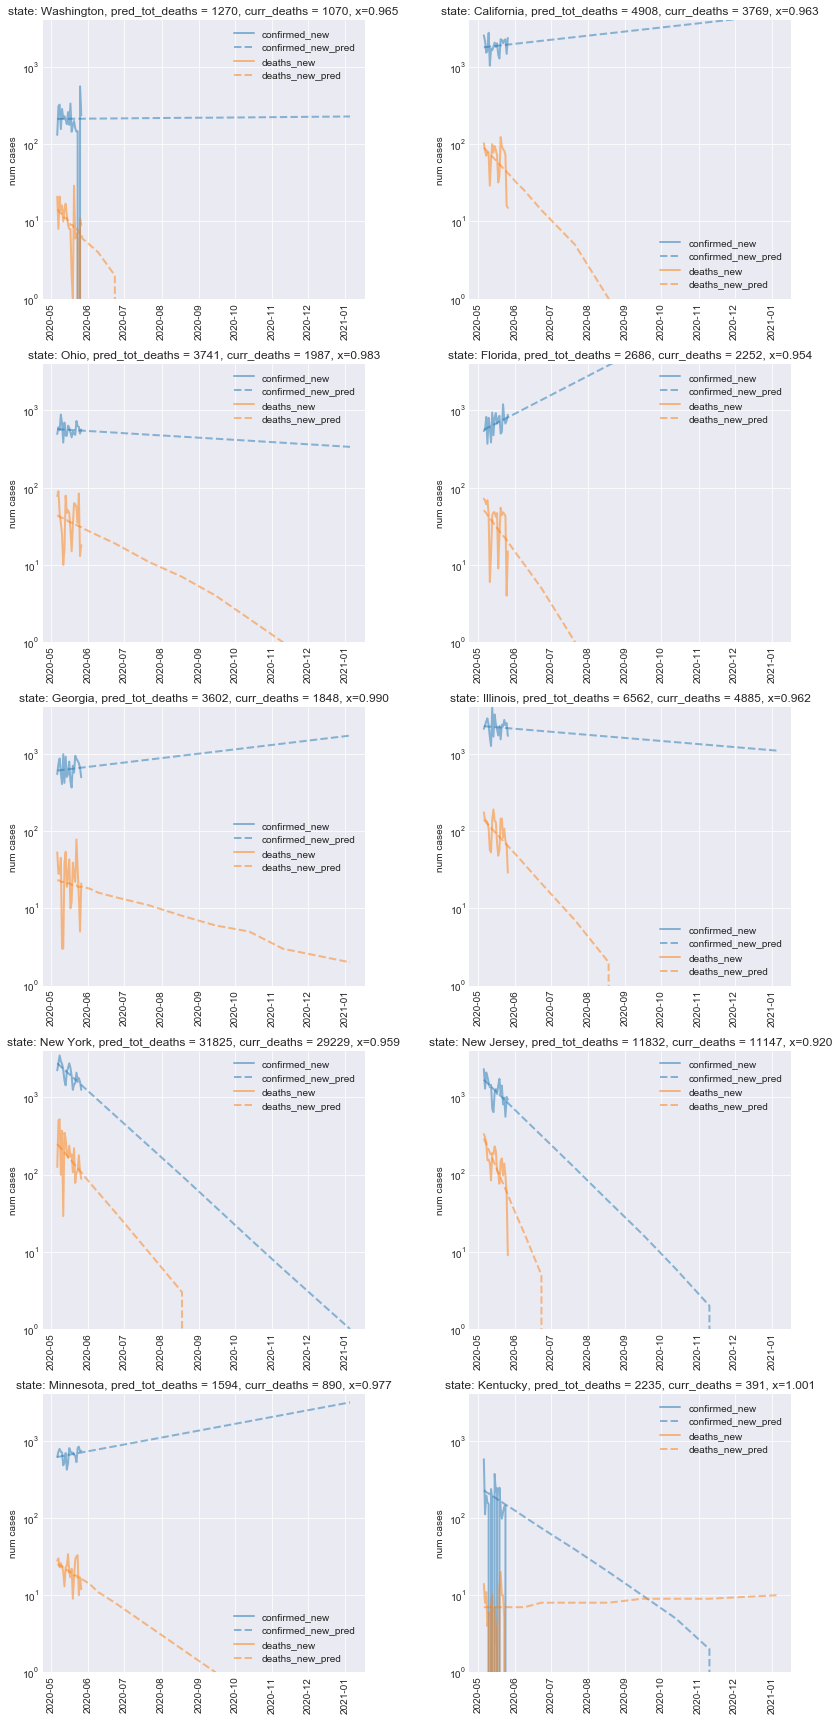

In [126]:
plot_forecasts_new(dfp_us_recent_1, col_locale='state', top_countries=['Washington', 'California', 'Ohio', 'Florida', 'Georgia', 'Illinois', 'New York', 'New Jersey', 'Minnesota', 'Kentucky'])

In [127]:
save_forecast_new(dfp_forecasts_us_out_1, dfp_us_recent_1, 'state', n_days_training=n_days_training)

saved forecast to predictions/new_cases_covid-19_state_forecast_from_2020-05-26_n_days_training=21.csv


### All states sorted by new deaths DESC

In [128]:
dfp_us_frac_new_increase = (dfp_us_recent_1[['state', 'frac_increase_deaths', 'frac_increase_confirmed']].
                             drop_duplicates().
                             sort_values(by='frac_increase_deaths', ascending=0).
                             reset_index(drop=True)
                            )
dfp_us_frac_new_increase

state  frac_increase_deaths  frac_increase_confirmed
0                   Nebraska              0.009275                -0.012838
1               Rhode Island              0.006305                -0.020427
2                       Iowa              0.003388                -0.004386
3                   Kentucky              0.001420                -0.022928
4                 New Mexico              0.000983                 0.001857
5                    Montana              0.000000                 0.008168
6                       Guam              0.000000                 0.009730
7             Virgin Islands              0.000000                 0.000000
8                    Vermont              0.000000                -0.013272
9                  Recovered              0.000000                 0.000000
10  Northern Mariana Islands              0.000000                -0.001316
11                    Alaska              0.000000                 0.009265
12                    Hawaii              0.000000                 0.001139
13                   Wyoming              0.000000                -0.001008
14            Grand Princess              0.000000                 0.000000
15          Diamond Princess              0.000000                 0.000000
16             West Virginia             -0.001646                 0.019363
17             New Hampshire             -0.001784                -0.009450
18                     Idaho             -0.003679                 0.025952
19                    Nevada             -0.004495                 0.017559
20                  Arkansas             -0.006867                 0.048700
21              North Dakota             -0.008305                 0.023092
22               Puerto Rico             -0.008556                 0.025887
23                     Maine             -0.009483                 0.019628
24                   Georgia             -0.009579                 0.004277
25                    Oregon             -0.010811                -0.058869
26                      Utah             -0.011300                 0.007296
27              South Dakota             -0.012989                -0.024895
28                  Virginia             -0.014103                -0.001246
29                  Delaware             -0.015458                -0.000926
30                 Louisiana             -0.016522                 0.020529
31                      Ohio             -0.017325                -0.002156
32      District of Columbia             -0.021305                -0.019004
33                  Oklahoma             -0.021679                 0.004014
34               Mississippi             -0.021869                 0.002929
35                 Minnesota             -0.022603                 0.006694
36                   Arizona             -0.023457                -0.007480
37                 Wisconsin             -0.023661                 0.014699
38                    Kansas             -0.026109                -0.065364
39            South Carolina             -0.027024                 0.014037
40                  Maryland             -0.028746                 0.000866
41                  Colorado             -0.031769                -0.036491
42                 Tennessee             -0.034369                 0.034617
43                Washington             -0.034919                 0.000297
44               Connecticut             -0.035126                -0.019445
45                California             -0.036874                 0.003996
46                  Illinois             -0.038148                -0.002978
47                  New York             -0.041220                -0.031798
48                   Alabama             -0.042329                 0.017164
49                     Texas             -0.042897                -0.013824
50             Massachusetts             -0.043643                -0.029490
51                   Florida             -0.046071                 0.01

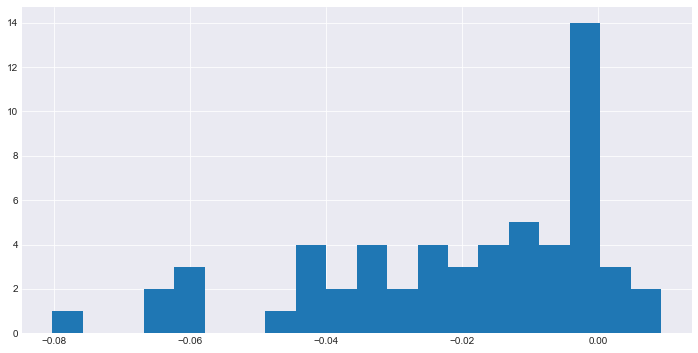

In [129]:
dfp_us_frac_new_increase.frac_increase_deaths.hist(bins=20)

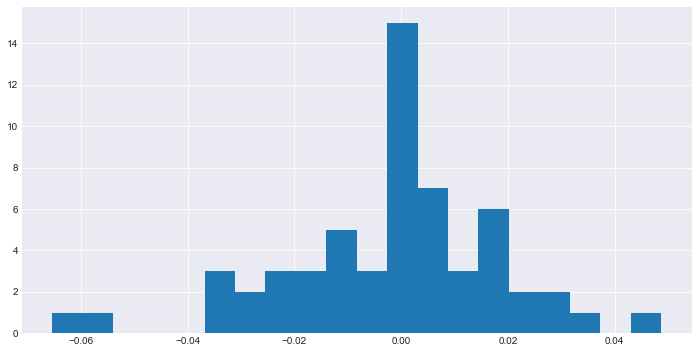

In [130]:
dfp_us_frac_new_increase.frac_increase_confirmed.hist(bins=20)

### Which states are increasing in new deaths <u>most</u> quickly?

In [131]:
dfp_us_frac_new_increase = (dfp_us_recent_1[['state', 'frac_increase_deaths', 'frac_increase_confirmed']].
                             drop_duplicates().
                             sort_values(by='frac_increase_deaths', ascending=0).
                             reset_index(drop=True)
                            )
dfp_us_frac_new_increase.head(10)

state  frac_increase_deaths  frac_increase_confirmed
0        Nebraska              0.009275                -0.012838
1    Rhode Island              0.006305                -0.020427
2            Iowa              0.003388                -0.004386
3        Kentucky              0.001420                -0.022928
4      New Mexico              0.000983                 0.001857
5         Montana              0.000000                 0.008168
6            Guam              0.000000                 0.009730
7  Virgin Islands              0.000000                 0.000000
8         Vermont              0.000000                -0.013272
9       Recovered              0.000000                 0.000000

### Which states are increasing in new deaths <u>least</u> quickly?

In [132]:
dfp_us_frac_new_increase.tail(10)

state  frac_increase_deaths  frac_increase_confirmed
48         Alabama             -0.042329                 0.017164
49           Texas             -0.042897                -0.013824
50   Massachusetts             -0.043643                -0.029490
51         Florida             -0.046071                 0.018657
52        Michigan             -0.058351                -0.019084
53         Indiana             -0.058876                -0.014001
54  North Carolina             -0.062185                 0.007037
55        Missouri             -0.063908                 0.001499
56    Pennsylvania             -0.065915                -0.030154
57      New Jersey             -0.080234                -0.034118

### Is there a day-of-the-week effect on new deaths?

In [133]:
dfp_us_recent_1['dow'] = dfp_us_recent_1['date'].apply(lambda x: x.weekday())
dfp_us_dow = dfp_us_recent_1.dropna(subset={'deaths_new'}).copy()

In [134]:
dfp_us_dow['death_delta'] = dfp_us_dow['deaths_new']- dfp_us_dow['deaths_new_pred']
dfp_us_dow['death_rel_delta'] = (dfp_us_dow['death_delta']) / dfp_us_dow['deaths_new_pred']

dfp_us_dow['confirmed_delta'] = dfp_us_dow['confirmed_new']- dfp_us_dow['confirmed_new_pred']
dfp_us_dow['confirmed_rel_delta'] = dfp_us_dow['confirmed_delta'] / dfp_us_dow['confirmed_new_pred']
dfp_us_dow_deltas = (dfp_us_dow.groupby(['state', 'dow'], as_index=False).
                     agg({'death_delta': np.mean, 
                          'death_rel_delta': np.median, 
                          'deaths_new': np.mean, 
                          'deaths_new_pred': np.mean, 
                          'confirmed_delta': np.mean, 
                          'confirmed_rel_delta': np.median})
                    )

In [135]:
dfp_us_dow_deltas[dfp_us_dow_deltas.state == 'Washington']

state  dow  death_delta  death_rel_delta  deaths_new  \
378  Washington    0    -1.666667        -0.166667    7.666667   
379  Washington    1    -1.000000         0.272727    8.000000   
380  Washington    2    11.333333         0.545455   22.333333   
381  Washington    3    -2.333333        -0.250000    8.666667   
382  Washington    4     2.000000        -0.100000   12.333333   
383  Washington    5    -1.000000        -0.200000    9.333333   
384  Washington    6    -1.333333        -0.111111    8.000000   

     deaths_new_pred  confirmed_delta  confirmed_rel_delta  
378         9.333333        94.666667             0.018779  
379         9.000000         1.666667             0.084507  
380        11.000000       -33.333333            -0.065421  
381        11.000000         4.333333            -0.145540  
382        10.333333        31.000000             0.225352  
383        10.333333       -52.333333            -0.262911  
384         9.333333        -6.000000             0.342723

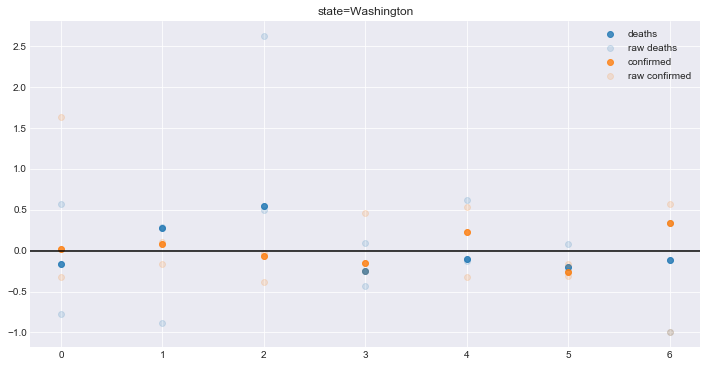

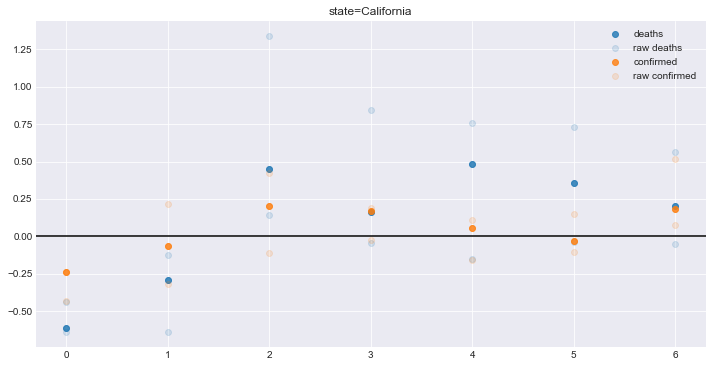

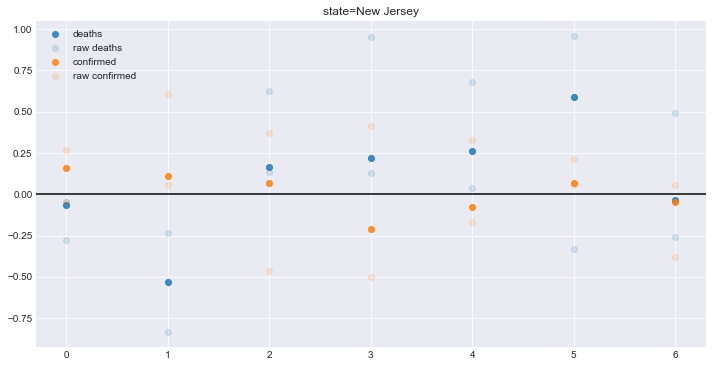

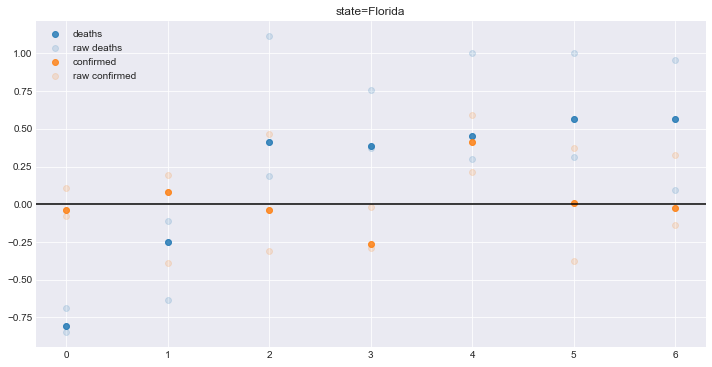

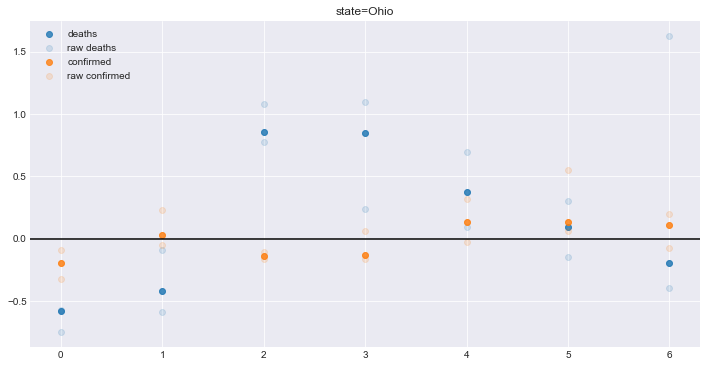

In [136]:
alpha_soft = 0.15
alpha_hard = 0.8
for state in ['Washington', 'California', 'New Jersey', 'Florida', 'Ohio']:
    dfp_plot = dfp_us_dow_deltas[(dfp_us_dow_deltas.state == state)]  #(dfp_us_dow_deltas.deaths_new >= 10) & 
    dfp_plot_raw = dfp_us_dow[dfp_us_dow.state == state]
    
    p = plt.plot(dfp_plot['dow'], dfp_plot['death_rel_delta'], 'o', alpha=alpha_hard, label='deaths')
    color = p[0].get_color()
    plt.plot(dfp_plot_raw['dow'], dfp_plot_raw['death_rel_delta'], 'o', alpha=alpha_soft, label='raw deaths', color=color)
    
    q = plt.plot(dfp_plot['dow'], dfp_plot['confirmed_rel_delta'], 'o', alpha=alpha_hard, label='confirmed')
    color = q[0].get_color()
    plt.plot(dfp_plot_raw['dow'], dfp_plot_raw['confirmed_rel_delta'], 'o', alpha=alpha_soft, label='raw confirmed', color=color)
    
    plt.legend(loc='best')
    plt.axhline(0, color='k')
    plt.title(f'state={state}')

    #plt.ylim([-0.5,0.5])
    #plt.ylim([-2,2])
    plt.show()